# Inteligencia Artificial para la Predicción de Incremental de Presiones por Interferencia
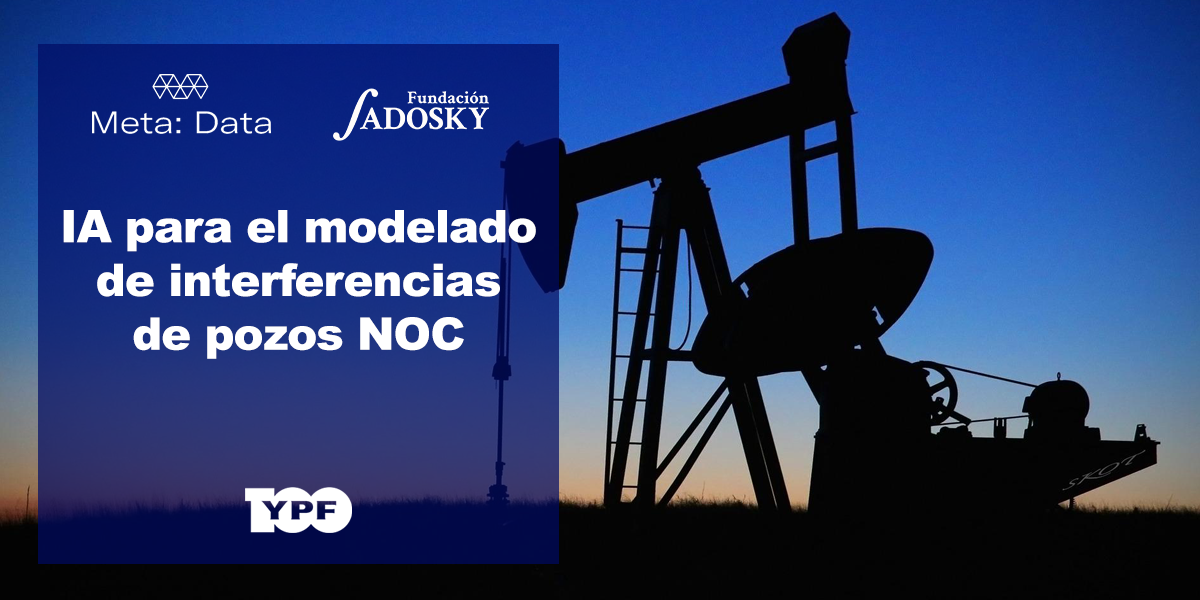

En esta competencia, YPF nos propone desarrollar un algoritmo de predicción del incremental de persión por interferencia durante la estimulación de pozos no convencionales de petróleo y gas.

Si bien los puntos de datos tienen una componente temporal, el dataset entregado no lo contempla. Veremos cómo esto afecta al algoritmo propuesto, y se plantean los siguientes objetivos:
- Analizar la data de modo general de un modo sencillo y elaborar donde fuera necesario
    - Al enfrentarse por primera vez un dominio desconocido, siempre resulta útil entender el contexto general.
    - Estando ya en contexto, siempre surgen preguntas que van más allá de lo básico. Por ejemplo, cruces de variables que puedan ayudar en el modelado.
    - En esta etapa suelen surgir hipótesis que pueden validarse respecto de la utilidad de las variables con fines predictivos.
- Pensar si las variables utilizadas filtran información futura
    - Como se dijo antes, el dataset no contempla información temporal de las etapas de los pozos. De este modo, tenemos que evaluar cómo sería desplegado el algoritmo propuesto en el mundo real.
    - Alternativamente, este ejercicio sirve de base para entender que mejoras se podrían al dataset y al circuito completo de entrenamiento/evaluación/inferencia.
- Validar localmente mejoras en los modelos
    - Desde el principio, mi objetivo es crear un pipeline prolijo de entrenamiento, que me permita validar mejoras localmente antes de hacer un submit.
    - En este sentido, me propuse abstraer todos los pasos en un pipeline del cual luego mostraré detalles.
        - Este proceso me permite tener un modelo que puede ser serializado para su uso productivo y contiene todas las transformaciones requeridas para hacer una predicción.
        - Permite también validar hipótesis varias sobre el modelo a utilizar.
        - Ayuda en la búsqueda de hiperparámetros de varios pasos.
- Aprender algo nuevo!
    - Estas competencias suelen ser un gran espacio para probar nuevos modelos, nuevas formas de trabajar, o ideas que quizás no serían aplicables en entornos que requieren una velocidad de iteración más rápida.

En cada paso iré describiendo mis observaciones, propuestas de mejoras, y conclusiones. Arranquemos.

# Imports

Importamos todas las bibliotecas necesarias para la ejecución del presente notebook.

Dependencias:
```
scikit-learn==1.1.3
lightgbm==3.3.3
pandas-profiling==3.2.0
matplotlib==3.5.3
numpy==1.21.1
pandas==1.4.3
seaborn==0.11.2
```

In [1]:
import operator as ops
import warnings
from functools import partial, reduce
from pprint import pprint
from typing import Optional

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from IPython.display import HTML, display
from ipywidgets import (
    Button,
    Dropdown,
    FloatSlider,
    IntProgress,
    IntSlider,
    Textarea,
    interact_manual,
    interactive,
)
from pandas_profiling import ProfileReport
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder

pd.options.display.max_columns = None

sns.set()

# Cargar y analizar datos

En esta sección, trabajo con uno de los datasets corregidos enviados por mail. La etapa de **EDA** (o _Análisis exploratorio de datos_) es la primera tarea a encarar en cualquier problema de Data Science. Y en particular, como mencioné antes, más cuando no se es familiar con el dominio.

Tenemos la ventaja de contar con un glosario de datos y varias presentaciones en formato PDF (de las sesiones dadas por la organización de la competencia para despejar dudas) que nos ayudan a entender el problema y los datos.

Si hiciera un análisis comprensivo manualmente de cada variable, este notebook sería mucho más largo de lo que es y más dificil de seguir, con un retorno bajo de inversión en tiempo para quien lo lea. Por tanto, voy a usar `pandas_profiling` para obtener un primer vistazo a los datos y luego manualmente iterar sobre los cruces que considere necesarios o sobre las variables que presenten anomalías.

## Glosario de datos
- **ID_FILA**: Identificador usado para subir la solución.
- **ID_EVENTO**: Identificador único de la línea.CAMPO: Nombre del Bloque al que pertenece el PAD Hijo.
- **FLUIDO**: Fluido que produce el PAD (Gas o Petróleo).
- **PAD_HIJO**: Nombre del PAD Hijo
- **HIJO**: Nombre del Pozo Hijo.
- **ETAPA_HIJO**: Número de Etapa de Fractura del pozo Hijo.
- **PADRE**: Nombre del Pozo Padre.
- **D3D**: Distancia tridimensional entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre $\dfrac{DX^2+DY^2+DZ^2}{2}$.
- **D2D**: Distancia en planta (vista de pajaro - sin considerar distancia vertical) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre $\left({DX^2+DY^2}\right)^\frac{1}{2}$.
- **DZ**: Distancia vertical (diferencia de altura) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre.
- **AZ**: Angulo respecto al norte que forma la linea recta que une la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre.
- **#_BARRERAS**: Cantidad de pozos padre entre el Pozo Hijo y el Pozo Padre considerado. Se consideran todos los pozos atravesados por la linea considerada en la D2D, y dentro de un espacio vertical que abarca toda la distancia vertical entre Pozo Hijo y Pozo Padre más 40m por encima y por debajo.
- **LINEAMIENTO**: Anomalías geológicas que atraviesan al Pozo Hijo y Pozo Padre.
- **WHP_i**: Presión al inicio de la interferencia.
- **delta_WHP**: Salto de presión generado por la interferencia. Desde la presión inicial al punto máximo o mínimo del salto.
- **ESTADO**: Estado del pozo al momento de la interferencia. Cerrado/Abierto.

In [2]:
df_participantes = pd.read_csv("Dataset participantes (corregido).csv")

## EDA

In [3]:
profile = ProfileReport(df_participantes, title="Dataframe", minimal=False)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Hay varias cosas que llaman la atención.

1. Hay un fuerte desbalanceo de Oil y Gas: aproximadamente 3 a 1
2. Los campos F, C y E (3 de los 9 presentes en el dataset) representan el 81% de las filas
3. Pareciera que hay picos en ciertos valores de etapa de los hijos, pero vemos a continuación que es un artefacto generado por la cantidad de bins del histograma
4. Hay outliers por mas de 3 ordenes de magnitud de D3D
    - Mi hipótesis es que es un error de puntos decimales y que deberia dividirse por 1000
    - La misma situación se repite para D2D
    - También se repite para AZ
5. El lineamiento está extremadamente desbalanceado
    - A continuación analizo la variable respecto del objetivo
6. Hay un 88% de deltas ceros
    - Veremos como baseline un modelo que prediga todos ceros como performa
7. La proporción de estados es de 2 a 1 (abiertos vs cerrados)

### Artefactos del histograma de etapas

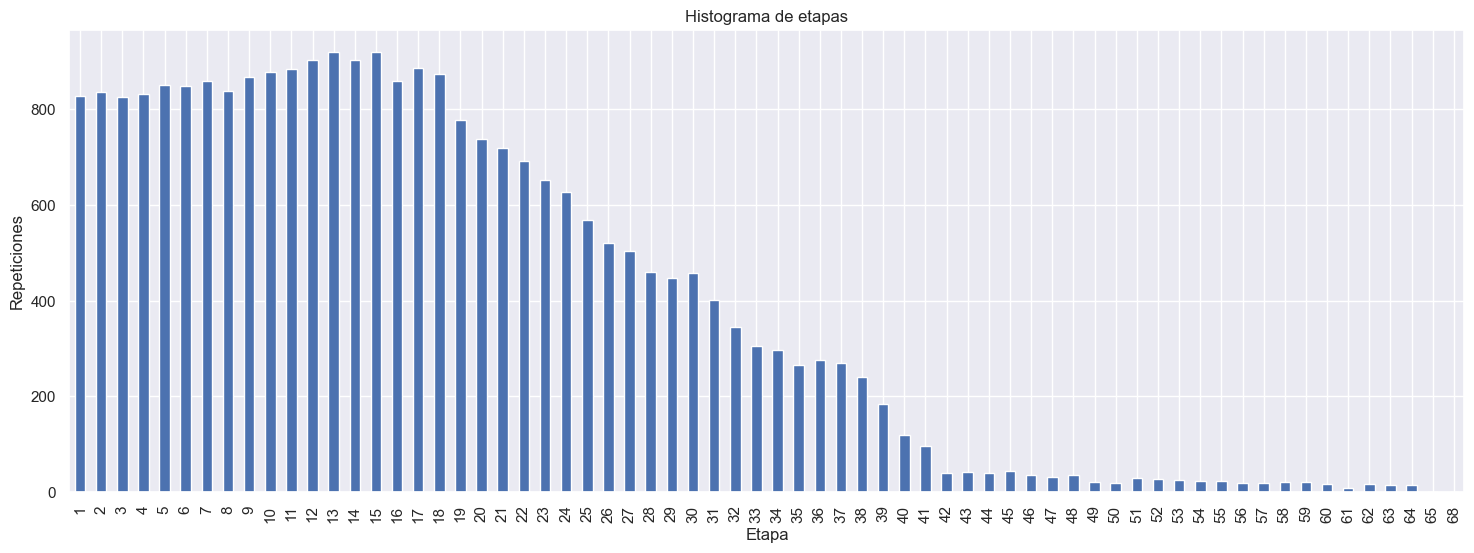

In [4]:
df_participantes.ETAPA_HIJO.value_counts().sort_index().plot(
    kind="bar", figsize=(18, 6), title="Histograma de etapas"
)
plt.xlabel("Etapa")
plt.ylabel("Repeticiones")
plt.show()

# Distribución de deltas

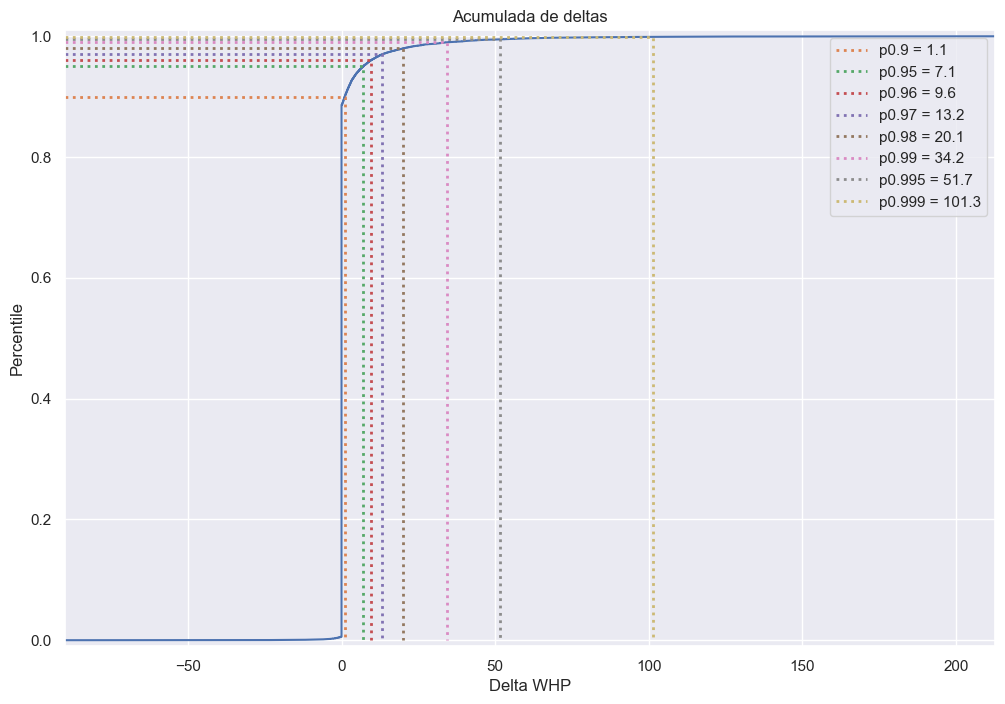

In [5]:
fig = plt.figure(dpi=100, figsize=(12, 8), facecolor='white')

x = df_participantes.delta_WHP.sort_values().values
y = np.linspace(0, 1, len(x))

plt.plot(x, y)
plt.ylim(-0.01, 1.01)
plt.xlim(x.min(), x.max())

xticks = []
yticks = []

for p in [90, 95, 96, 97, 98, 99, 99.5, 99.9]:
    p /= 100
    xp = x[(y <= p).argmin()]
    yp = p
    a  = [[x.min(), yp], [xp, yp], [xp, 0]]
    xticks.append(xp)
    yticks.append(p)
    plt.plot(*zip(*a), label=f"p{p:.3g} = {xp}", linestyle=":", linewidth=2)

#plt.xticks(ticks=xticks, labels=[f"{x}" for x in xticks], fontsize=8)
#plt.yticks(ticks=yticks, fontsize=6)

plt.title("Acumulada de deltas")
plt.xlabel("Delta WHP")
plt.ylabel("Percentile")

#plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=True, labeltop=False, labelright=False, labelbottom=True)

plt.legend()

plt.show()

### ¿Hay presiones iniciales negativas?

In [6]:
(df_participantes.WHP_i < 0).value_counts(normalize=True).mul(100)

False    99.62946
True      0.37054
Name: WHP_i, dtype: float64

Estos valores muy probablemente se deban a erorres de medición, como ser los que pueda generar un instrumento descalibrado.

### ¿Son las presiones similares entre Oil y Gas?

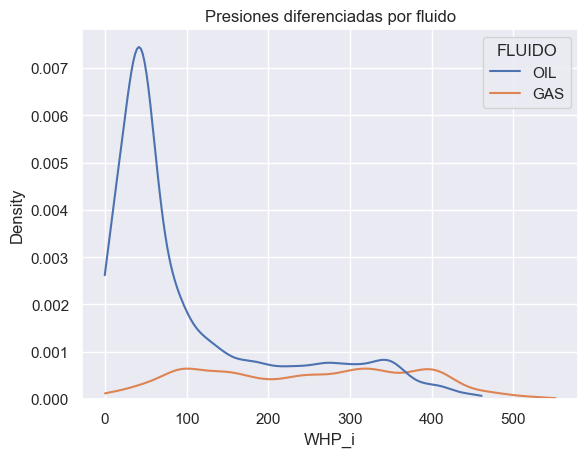

In [7]:
sns.kdeplot(x=df_participantes.WHP_i, cut=0, hue=df_participantes.FLUIDO)
plt.title("Presiones diferenciadas por fluido")
plt.show()

Tenemos distribuciones muy diferentes:
- Oil con un pico alrededor de 50
- Gas mas uniforme

### ¿Son los deltas similares entre Oil y Gas?

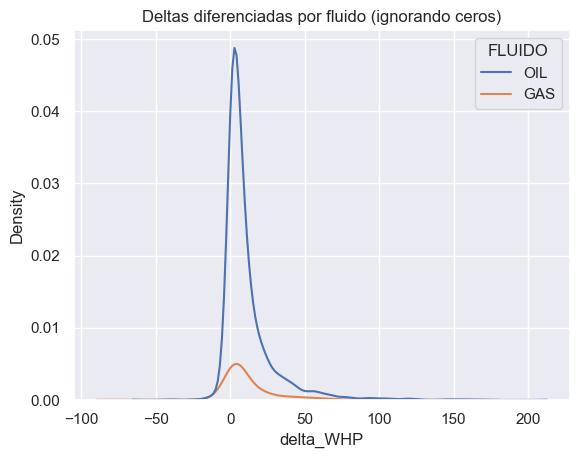

In [8]:
mask = df_participantes.delta_WHP != 0
sns.kdeplot(
    x=df_participantes[mask].delta_WHP, cut=0, hue=df_participantes[mask].FLUIDO
)
plt.title("Deltas diferenciadas por fluido (ignorando ceros)")
plt.show()

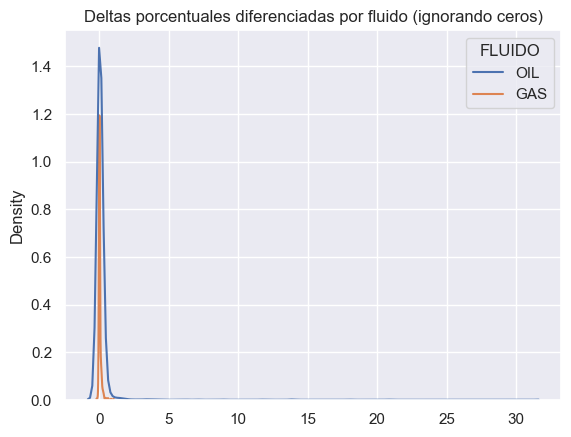

In [9]:
mask = df_participantes.delta_WHP != 0
sns.kdeplot(
    x=df_participantes[mask].delta_WHP / df_participantes[mask].WHP_i,
    cut=0,
    hue=df_participantes[mask].FLUIDO,
)
plt.title("Deltas porcentuales diferenciadas por fluido (ignorando ceros)")
plt.show()

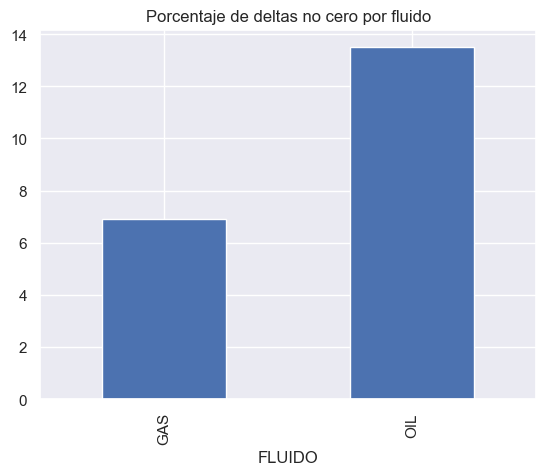

In [10]:
df_participantes.groupby("FLUIDO").delta_WHP.agg(lambda x: np.mean(x != 0) * 100).plot(
    kind="bar"
)
plt.title("Porcentaje de deltas no cero por fluido")
plt.show()

Los porcentajes entre fluidos tienen una enorme diferencia, casi el doble. Sin embargo, las distribuciones se ven similares.

### Deltas por lineamiento

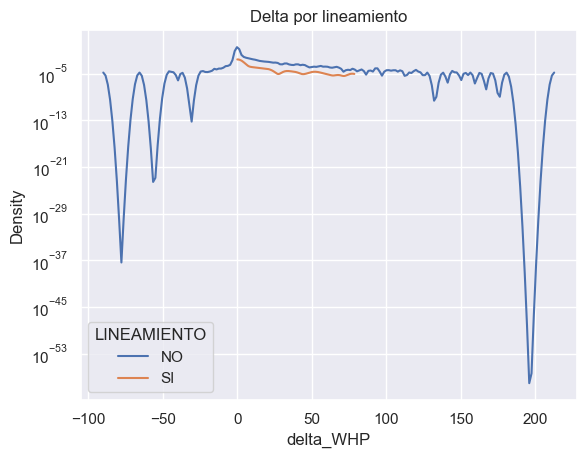

In [11]:
sns.kdeplot(x=df_participantes.delta_WHP, hue=df_participantes.LINEAMIENTO, cut=0)
plt.title("Delta por lineamiento")
plt.yscale("log")
plt.show()

In [12]:
df_participantes.groupby("LINEAMIENTO").delta_WHP.agg(["mean", "max", "min", "std"])

mean    max   min       std
LINEAMIENTO                                 
NO           1.344759  212.8 -90.0  7.521509
SI           2.786988   78.6   0.0  9.573740

In [13]:
df_participantes[
    df_participantes.delta_WHP.between(
        df_participantes[df_participantes.LINEAMIENTO == "SI"].delta_WHP.min(),
        df_participantes[df_participantes.LINEAMIENTO == "SI"].delta_WHP.max(),
    )
].groupby("LINEAMIENTO").delta_WHP.agg(["mean", "median", "std"])

mean  median       std
LINEAMIENTO                            
NO           1.186788     0.0  5.614561
SI           2.786988     0.0  9.573740

En el rango donde el lineamiento `SI` está presente, hay poca variación de los deltas, por tanto no la considero una variable útil para el modelo.

### Padres vs hijos

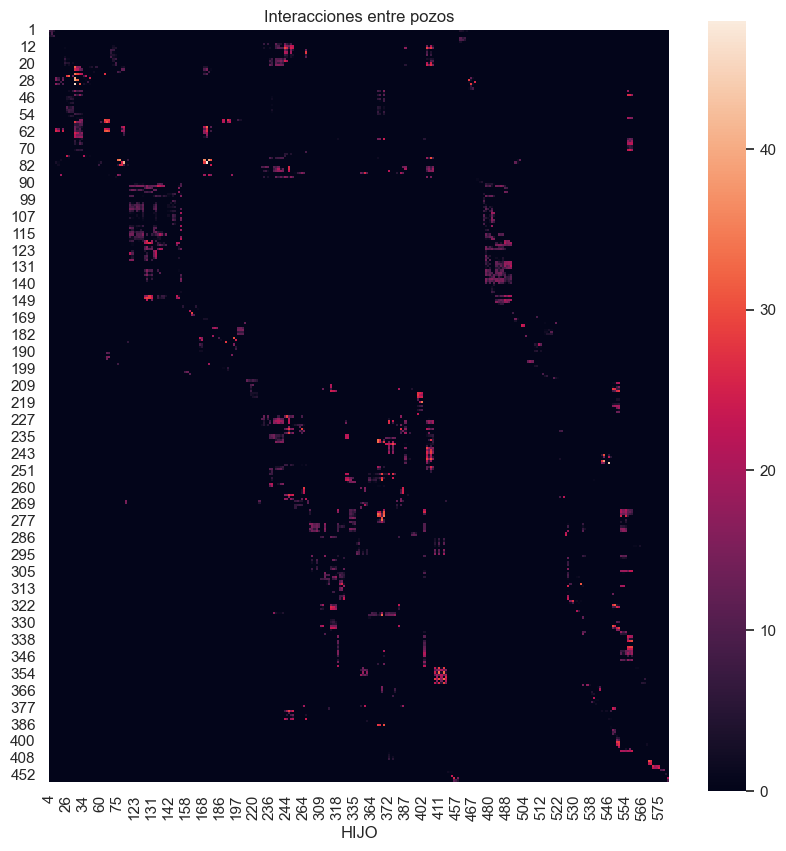

In [14]:
cross_pozos = df_participantes.pivot_table(
    index="PADRE", columns="HIJO", values="ID_EVENTO", aggfunc="count", fill_value=0
)
cross_pozos.index = cross_pozos.index.str.replace("Pozo ", "").values.astype(int)
cross_pozos.sort_index(inplace=True)
cross_pozos.columns = cross_pozos.columns.str.replace("Pozo", "").astype(int)
cross_pozos = cross_pozos[sorted(cross_pozos.columns)]
plt.figure(figsize=(10, 10))
sns.heatmap(cross_pozos, square=True)
plt.title("Interacciones entre pozos")
plt.show()

El gráfico anterior es más vistoso que útil. _Sin embargo_ algo que me resulta interesante es que pareciera haber bloques de padres con identificadores consecutivos (o cercanos) que interactúan con bloques de pozos hijos.

### Deltas históricos por padre

En esta sección (interactiva, se invita al lector a jugar con el dropdown) podemos apreciar los deltas por hijo para cada pozo padre, ordenados por etapa del hijo.

In [15]:
def plot_deltas_por_padre(padre):
    df_padre = df_participantes.loc[df_participantes.PADRE == f"Pozo {padre}"]
    hijos = df_padre.HIJO.unique()
    nhijos = len(hijos)
    netapas = df_padre.ETAPA_HIJO.max()
    fig, axes = plt.subplots(
        ncols=1,
        nrows=nhijos,
        figsize=(0.5 * netapas, 1.65 * nhijos),
        sharex=True,
        sharey=True,
        dpi=110,
    )
    for ax, hijo in zip(axes, hijos):
        df_hijo = df_padre.loc[df_padre.HIJO == hijo]
        ax.set_ylabel(f"{hijo}")
        for (etapa, delta) in df_hijo[["ETAPA_HIJO", "delta_WHP"]].to_records(
            index=False
        ):
            ax.plot([etapa, etapa], [0, delta], color="b", linestyle="--", zorder=1)

        ax.scatter(
            x=df_hijo.ETAPA_HIJO,
            y=df_hijo.delta_WHP,
            facecolors="b",
            edgecolors="b",
            s=40,
            c=df_hijo.delta_WHP == 0,
        )

        mean_delta = df_hijo.delta_WHP.mean()
        ax.axhline(
            y=mean_delta,
            label=f"Mean delta ({mean_delta:.2f})",
            color="grey",
            linestyle=":",
        )
        ax.legend()

    plt.xticks(ticks=range(df_padre.ETAPA_HIJO.min(), df_padre.ETAPA_HIJO.max() + 1))
    plt.suptitle(f"Deltas del pozo {padre} por etapa del hijo")
    plt.xlabel("Etapa del hijo")
    plt.tight_layout()
    plt.setp(
        axes,
        ylim=(
            df_padre.delta_WHP.min() * 1.1 - 0.1,
            df_padre.delta_WHP.max() * 1.1 + 0.1,
        ),
    )
    plt.show()


inter = interact_manual(
    plot_deltas_por_padre,
    padre=Dropdown(
        options=df_participantes.PADRE.str.replace("Pozo ", "")
        .astype(int)
        .sort_values()
        .unique(),
        index=0,
    ),
)

interactive(children=(Dropdown(description='padre', options=(1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17,…

#### Algunos ejemplos

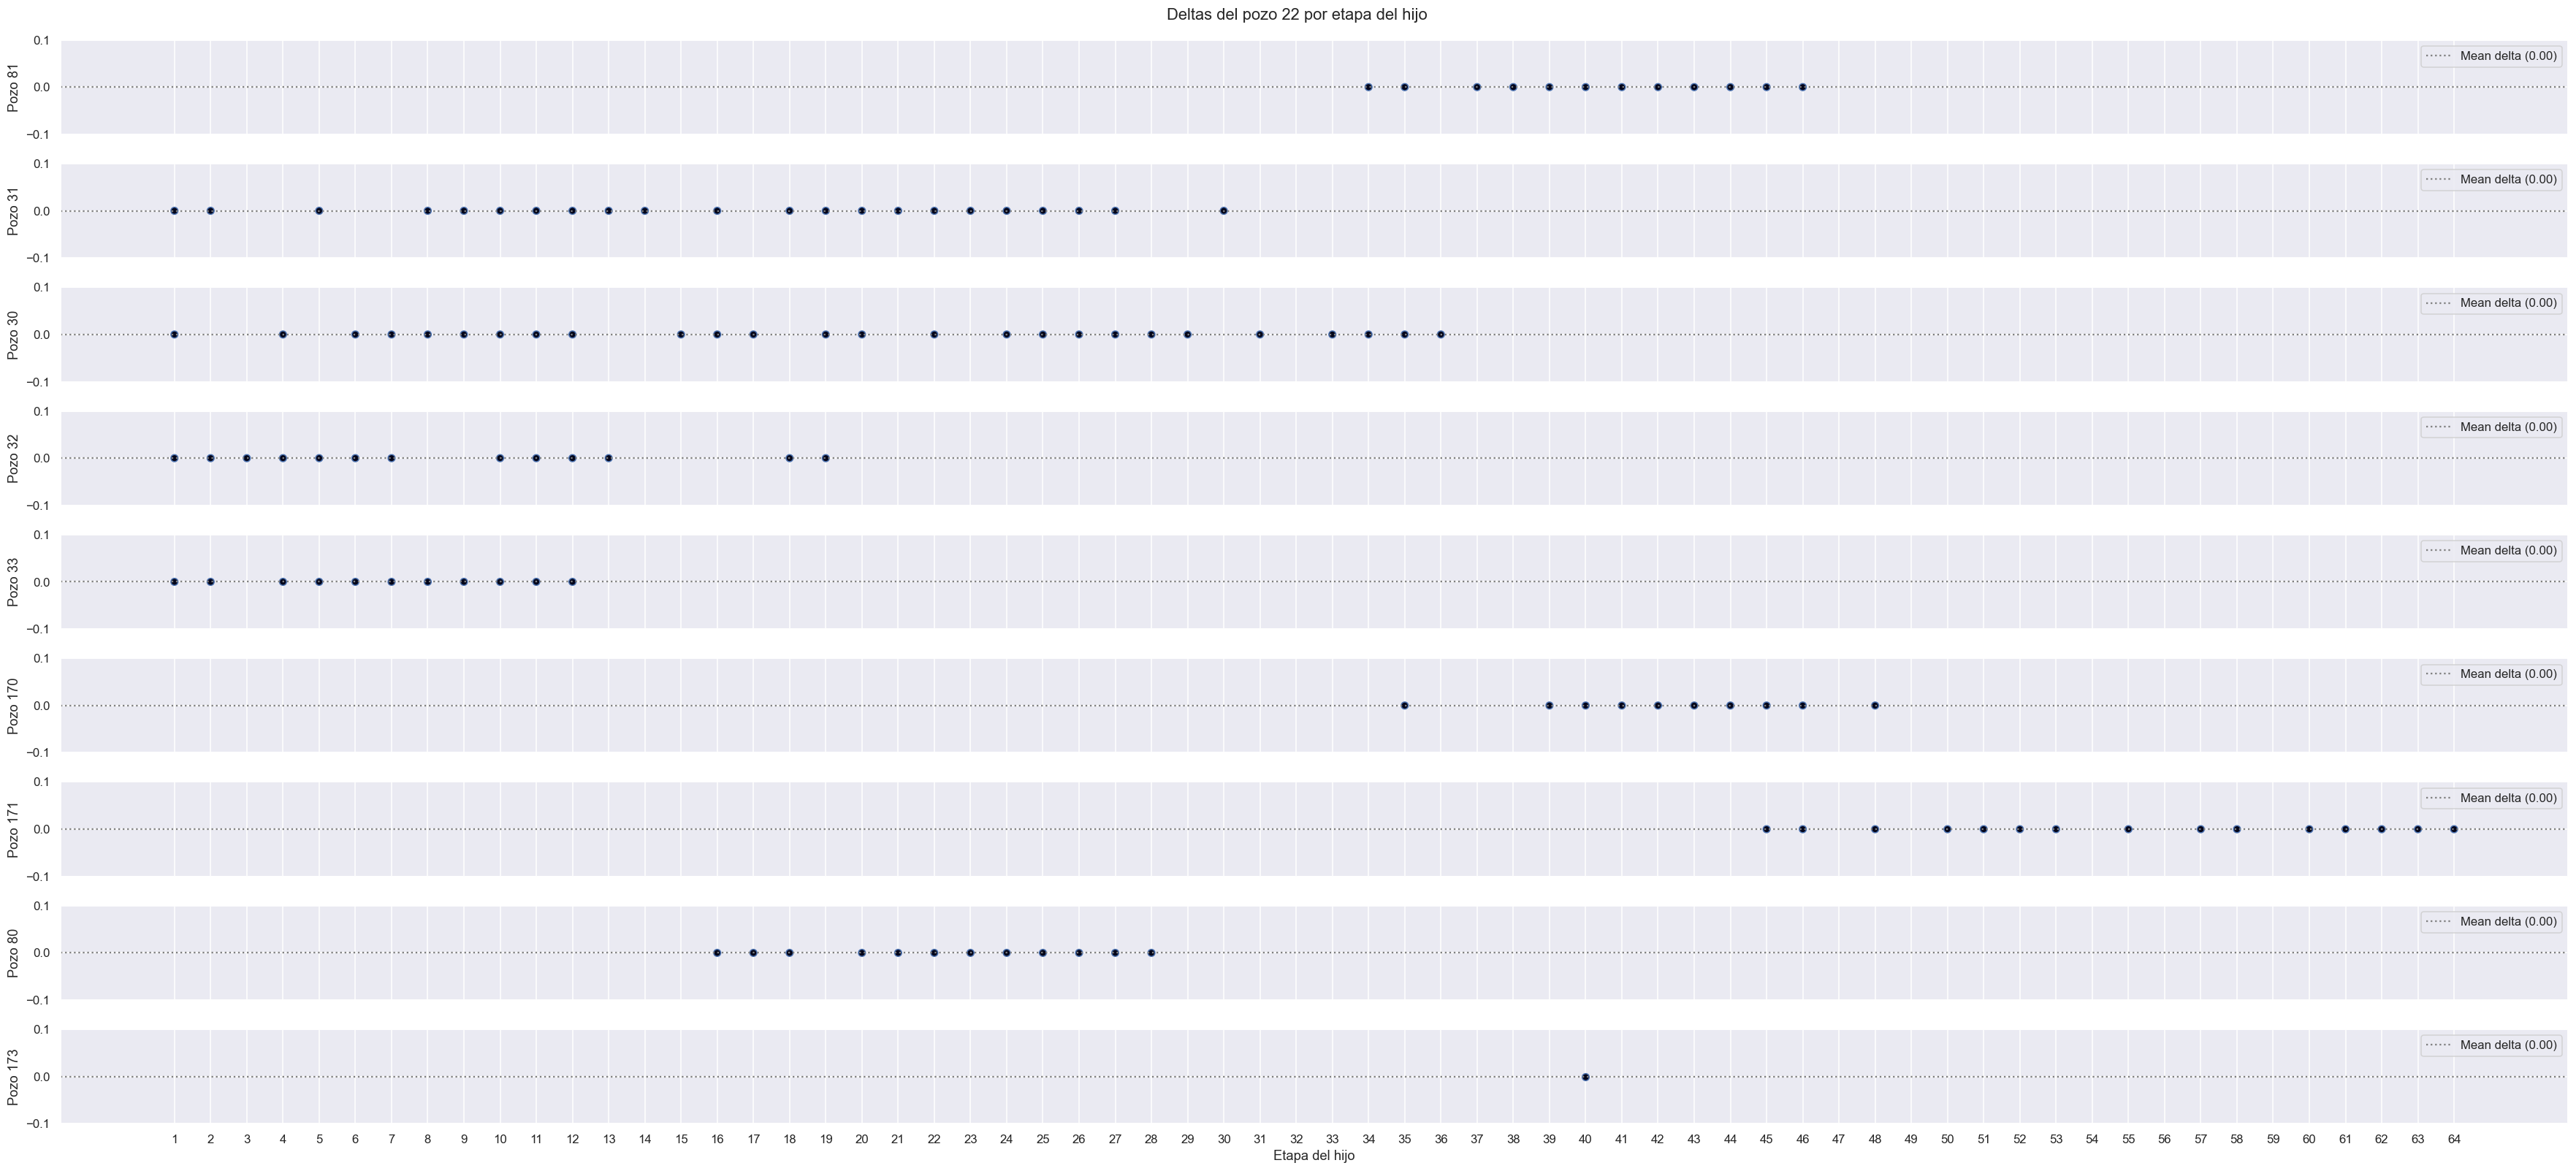

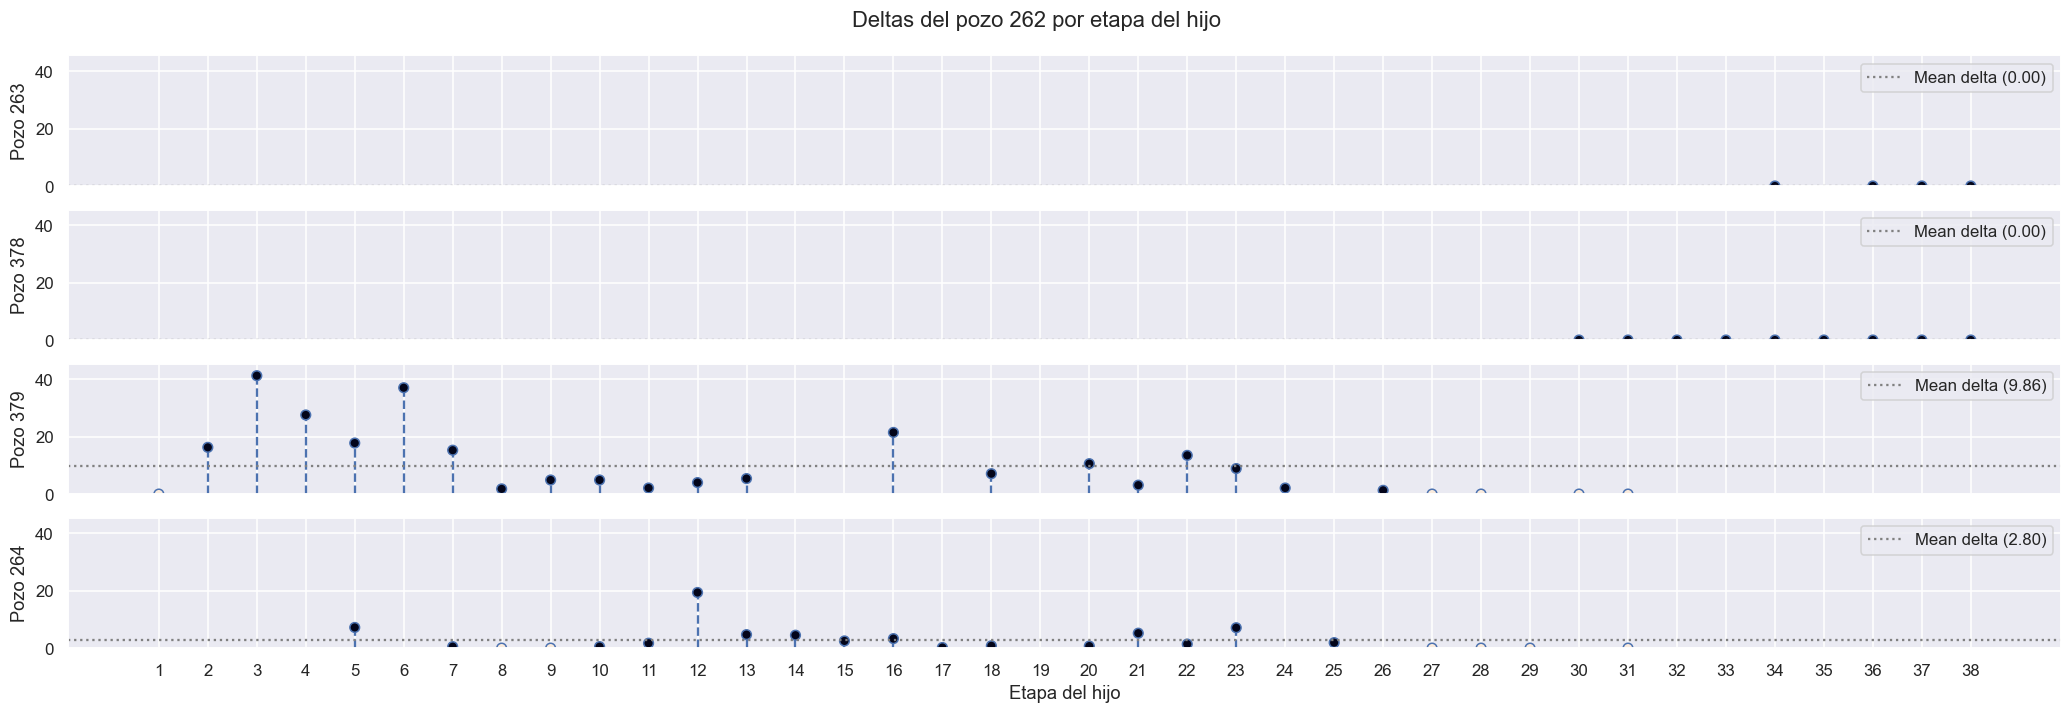

Viendo varios valores podemos observar que:
- Hay discontinuidades respecto de las etapas de los hijos
    - Desconocemos si esto se debe a que está en el dataset de evaluación, no se tienen observaciones o la data esta sampleada
- No tenemos forma de ordenar la data por etapas "globales"
    - Un punto de mejora en el dataset sería agregar los timestamps de las mediciones, de modo tal que podamos separar la data temporalmente y agregar features laggeadas en base a ello

# Feature engineering
En esta sección me limito a _arreglar_ distintas columnas según lo mencionado antes.

In [16]:
df_participantes.rename(columns={"#_BARRERAS": "CANT_BARRERAS"}, inplace=True)
df_participantes.CANT_BARRERAS = df_participantes.CANT_BARRERAS.astype(int)

In [17]:
expon = np.log10(df_participantes.AZ).round()
expon = (expon >= 3) * (df_participantes.AZ > 360) * expon
df_participantes.AZ /= np.power(10, expon)

In [18]:
expon = np.log10(df_participantes.D2D / df_participantes.D3D).round()
expon = (expon >= 3) * expon
df_participantes.D2D /= np.power(10, expon)

In [19]:
expon = np.log10(df_participantes.D3D / df_participantes.D2D).round()
expon = (expon >= 3) * expon
df_participantes.D3D /= np.power(10, expon)

Si lo anterior fuera correcto, veríamos que se cumple el teorema de pitágoras en todos los casos.

In [20]:
print(
    f"Porcentaje donde se cumple (tolerancia absoluta de 1e-2): {np.isclose(0, df_participantes.D2D ** 2 + df_participantes.DZ ** 2 - df_participantes.D3D ** 2, atol=1e-2).mean():.2%}"
)

Porcentaje donde se cumple (tolerancia absoluta de 1e-2): 100.00%


In [21]:
CAT_COLS = [
    "CAMPO",
    "FLUIDO",
    "PAD_HIJO",
    # "ETAPA_HIJO",
    "HIJO",
    "PADRE",
    "LINEAMIENTO",
    "ESTADO",
    # "CANT_BARRERAS",
]

NUM_COLS = [
    "D3D",
    "D2D",
    "DZ",
    "AZ",
    "WHP_i",
    "ETAPA_HIJO",
    "CANT_BARRERAS",
]

FEATURES = [*CAT_COLS, *NUM_COLS]

## Feature transformers
Mi idea es, a fines de tener un pipeline prolijo y escalable, explotar los [transformers](https://scikit-learn.org/stable/data_transforms.html) de `scikit-learn`. Implementaré las creaciones de features que considere encapsuladas en clases, de modo de poder calcular las features con un dataset de entrenaiento y luego usarlas en el sample de test.

Al tener todas las transformaciones encapsuladas de este modo, puedo encadenarlas en un [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) y con [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) controlar sus hiperparametros.

Entre estos hiperparametros, quisiera controlar que columnas tomar para las predicciones, de que modo se calculan, y si son numericas o categoricas. Siendo que son transformaciones custom, me limito a implementarlas según los lineamientos de la biblioteca.

Algo importante a destacar de lo anterior: es muy poderoso como proceso de desarrollo lo planteado. Dado que cualquier idea de una nueva feature derivada del dataset puedo implementarla y encadenarla, eventualmente se deja al grid search decidir si vale la pena o no incluirla en el modelo final. Y este modelo final contendrá todas las transformaciones entrenadas con data de train, de modo que evitamos filtrado de información.

Una ventaja adicional es que puedo documentar cada transformación individualmente. Se invita al lector a revisar los _docstrings_ a fin de entender el pipeline final.

In [22]:
class HijoFuePadre(BaseEstimator, TransformerMixin):
    """Indicador booleano sobre si el hijo considerado ha sido considerado padre."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.padres = set(X.PADRE.values)
        return self

    def transform(self, X):
        return X.HIJO.isin(self.padres)

In [23]:
class PandasFeatureAppender(BaseEstimator, TransformerMixin):
    """Concatena features a un dataframe."""

    def __init__(self, transformations):
        self.transformations = transformations

    def fit(self, X, y=None):
        for _, t in self.transformations:
            t.fit(X, y)
        return self

    def transform(self, X):
        transformations = []
        colnames = []
        for colname, t in self.transformations:
            colnames.append(colname)
            transformations.append(t.transform(X))

        for colname, transformation in zip(colnames, transformations):
            X[colname] = transformation
        return X

In [24]:
class PandasColumnsSelector(BaseEstimator, TransformerMixin):
    """Selecciona columnas de features de un dataset."""

    def __init__(
        self, categorical, numerical, remainder="drop", verbose=False, order=None
    ):
        self.categorical = categorical
        self.numerical = numerical
        self.remainder = remainder
        self.verbose = verbose
        self.order = order

        if remainder not in ("drop", "passthrough"):
            raise ValueError(f"Action {remainder} not understood")

        if remainder == "passthrough":
            raise NotImplemented()

    def fit(self, X, y=None):
        if self.order is None:
            self._order = [*self.categorical, *self.numerical]
        else:
            self._order = []
            for name in self.order:
                if name.startswith("group::"):
                    name = name[len("group::") :]
                    for col in {
                        "numerical": self.numerical,
                        "categorical": self.categorical,
                    }[name]:
                        if col not in self.order:
                            self._order.append(col)
                else:
                    self._order.append(name)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            if not len(self._order) == X.shape[1]:
                msg = f"Shape of array is {X.shape}, but got {len(self._order)} columns, {X[0]}, {self._order}"
                print(msg)
                raise RuntimeError(msg)
            X = pd.DataFrame(X, columns=self._order)

        missing = set([*self.categorical, *self.numerical]) - set(X.columns)
        if len(missing) > 0 and self.verbose:
            warnings.warn(f"Missing columns: {missing}")

        for col in self.categorical:
            if col in missing:
                continue
            X[col] = X[col].astype("category")

        for col in self.numerical:
            if col in missing:
                continue
            X[col] = pd.to_numeric(X[col])

        remainder_cols = set(X.columns) - set(self.categorical) - set(self.numerical)
        if self.remainder == "drop":
            if self.verbose:
                display(f"Dropping columns: {remainder_cols}")
            X = X.drop(columns=remainder_cols)
        self.returned_cols = [
            c for c in self._order if c not in missing and c in X.columns
        ]
        return X[self.returned_cols]

In [25]:
class CantHijos(BaseEstimator, TransformerMixin):
    """Cantidad de hijos que se conocen para el padre."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.hijos_por_padre = X.groupby("PADRE").HIJO.nunique().to_dict()
        return self

    def transform(self, X):
        return X.PADRE.map(self.hijos_por_padre)

In [26]:
class PadreHijo(BaseEstimator, TransformerMixin):
    """Feature de padre con hijo concatenado"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.PADRE + "//" + X.HIJO

In [27]:
class CantPadres(BaseEstimator, TransformerMixin):
    """Cantidad de padres que se conocen para el hijo."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.padres_por_hijo = X.groupby("HIJO").PADRE.nunique().to_dict()
        return self

    def transform(self, X):
        return X.HIJO.map(self.padres_por_hijo)

In [28]:
class PreviousNonZeroDeltas(BaseEstimator, TransformerMixin):
    """Agregaciones estadisticas de deltas no cero por hijo en etapas anteriores a la considerada.
    
    Por ejemplo, si se está considerando la etapa 3 y se conocen los valores para las etapas
    1, 2, 3, 5 y 7, en ese caso se calculan las agregaciones para las etapas 1 y 2.
    
    Se considera si el delta fue cero o no, calculando el total de deltas no cero y la proporción
    de deltas no cero.
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        _X = X.copy().sort_values(["PADRE", "HIJO", "ETAPA_HIJO"])
        _X["delta"] = y != 0.0

        self.counts = (
            _X.groupby(["PADRE", "HIJO"])[["delta", "ETAPA_HIJO"]]
            .expanding()
            .agg({"delta": ["sum", "mean"], "ETAPA_HIJO": "max"})
            .fillna(0)
        )

        self.counts.columns = [
            "_".join(col).strip() for col in self.counts.columns.values
        ]

        self.counts = self.counts.reset_index(
            drop=False, level=["PADRE", "HIJO"]
        ).rename(columns={"ETAPA_HIJO_max": "ETAPA_HIJO"})
        self.counts.ETAPA_HIJO = self.counts.ETAPA_HIJO.astype(int)

        return self

    def transform(self, X):
        _X = (
            pd.merge_asof(
                X.sort_values(by=["ETAPA_HIJO"]),
                self.counts.sort_values(by=["ETAPA_HIJO"]),
                by=["PADRE", "HIJO"],
                on="ETAPA_HIJO",
            )
            .set_index("ID_FILA")
            .reindex(X.ID_FILA)
            .reset_index()
            .set_index(X.index)
        )
        # Reindexing causes trouble!
        return _X


class PreviousNonZeroDeltasAggs(BaseEstimator, TransformerMixin):
    """Agregaciones estadisticas de deltas por hijo en etapas anteriores a la considerada.
    
    Por ejemplo, si se está considerando la etapa 3 y se conocen los valores para las etapas
    1, 2, 3, 5 y 7, en ese caso se calculan las agregaciones para las etapas 1 y 2.
    
    Se consideran los valores de los deltas, sumarizandolos con agregaciones.
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        _X = X.copy().sort_values(["PADRE", "HIJO", "ETAPA_HIJO"])
        _X["delta"] = y

        self.counts = (
            _X.groupby(["PADRE", "HIJO"])[["delta", "ETAPA_HIJO"]]
            .expanding()
            .agg({"delta": ["sum", "mean"], "ETAPA_HIJO": "max"})
            .fillna(0)
        )

        self.counts.columns = [
            "_".join(col).strip() for col in self.counts.columns.values
        ]
        self.counts = self.counts.add_prefix("pnzd_agg_")

        self.counts = self.counts.reset_index(
            drop=False, level=["PADRE", "HIJO"]
        ).rename(columns={"pnzd_agg_ETAPA_HIJO_max": "ETAPA_HIJO"})
        self.counts.ETAPA_HIJO = self.counts.ETAPA_HIJO.astype(int)

        return self

    def transform(self, X):
        _X = (
            pd.merge_asof(
                X.sort_values(by=["ETAPA_HIJO"]),
                self.counts.sort_values(by=["ETAPA_HIJO"]),
                by=["PADRE", "HIJO"],
                on="ETAPA_HIJO",
            )
            .set_index("ID_FILA")
            .reindex(X.ID_FILA)
            .reset_index()
            .set_index(X.index)
        )
        # Reindexing causes trouble!
        return _X

In [29]:
class TrigFeatures(BaseEstimator, TransformerMixin):
    """Agrega features trigonometricas.
    
    Tenemos un triangulo formado por las columnas DZ, D3D y D2D.
    D3D es la hipotenusa del mismo.
    
    Conociendo estos valores, podemos calcular rho, el angulo entre
    D3D y D2D, que nos da una idea de que tan lejos está.
    
    AZ es el angulo respecto al norte que forma la linea recta que une la etapa de fractura
    del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre.
    
    Como esto está expresado en grados, tenemos el problema de que 359 y 1 son valores muy
    lejanos numericamente pero muy cercanos conceptualmente. Por tanto hacemos una descomposición
    en seno y coseno de modo que sean valores mas cercanos.
    
    Consultar https://www.researchgate.net/figure/Representation-of-cyclical-features-as-sin-and-cos-components_fig5_326542245
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["sin_AZ"] = np.sin(X.AZ / (2 * np.pi))
        X["cos_AZ"] = np.cos(X.AZ / (2 * np.pi))
        X["rho"] = np.arctan(X.DZ / X.D2D)
        return X

In [30]:
def nan_aggfunc(z, f):
    z = z.values
    xlen = z.shape[0]
    if xlen == 1:
        return list(np.repeat(np.nan, 1))
    z = np.ones((xlen, xlen)) * z
    z[np.eye(xlen, xlen).astype(bool)] = np.nan
    return list(f(z, axis=1))


def aggfunc_max(x):
    retval = nan_aggfunc(x, np.nanmax)
    return retval


def aggfunc_min(x):
    return nan_aggfunc(x, np.nanmin)


def aggfunc_mean(x):
    return nan_aggfunc(x, np.nanmean)


def aggfunc_var(x):
    return nan_aggfunc(x, np.nanvar)


def aggfunc_std(x):
    return nan_aggfunc(x, np.nanstd)


def aggfunc_median(x):
    return nan_aggfunc(x, np.nanmedian)

In [31]:
class WellDeltasStatisticalSummary(BaseEstimator, TransformerMixin):
    """Calcular estadísticas de los deltas por pozo padre.
    
    Esto se hace sin considerar la etapa actual, solo las demás.
    """

    def __init__(self, on=("PADRE", "HIJO",), by="ID_FILA"):
        self.on = on
        self.by = by

    def fit(self, X, y=None):
        # display("fit")
        cols = [
            "aggfunc_max",
            "aggfunc_min",
            "aggfunc_mean",
            "aggfunc_median",
            "aggfunc_std",
            "aggfunc_var",
        ]
        # display(f"Cols @ fit: {X.columns}")
        _X = X.copy()
        _X = _X.sort_values([*self.on, self.by])

        self.known = (
            _X.groupby([*self.on])
            .delta_WHP.agg(
                [
                    aggfunc_max,
                    aggfunc_min,
                    aggfunc_mean,
                    aggfunc_median,
                    aggfunc_std,
                    aggfunc_var,
                ]
            )
            .explode(cols)
            .set_index(_X[self.by])
            .rename(columns={k: k.replace("aggfunc_", "delta_agg_") for k in cols})
        )

        self.unknown = (
            X.groupby([*self.on])
            .delta_WHP.agg(["max", "min", "mean", "median", "std", "var"])
            .add_prefix("delta_agg_")
        )

        return self

    def transform(self, X):
        if X[self.by].isin(self.known.index).mean() == 1:
            retval = X.merge(self.known, left_on=self.by, right_index=True, how="left")
        elif X[self.by].isin(self.known.index).mean() == 0:
            retval = X.merge(
                self.unknown, left_on=self.on, right_index=True, how="left"
            )
        else:
            retval = pd.concat([
                X[X[self.by].isin(self.known.index)].merge(self.known, left_on=self.by, right_index=True, how="left"),
                X[~X[self.by].isin(self.known.index)].merge(self.unknown, left_on=self.on, right_index=True, how="left")
            ]).reindex(X.index)
            #raise RuntimeError(f"Gotta mix {X[self.by].isin(self.known.index).mean()}")

        for col in [
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ]:
            retval[col] = retval[col].astype(np.float64)

        return retval

In [32]:
class DeltaWithLastKnownWHP(BaseEstimator, TransformerMixin):
    """Calcular delta con respecto al anterior WHP inmediatamente mas bajo."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.counts = X.sort_values(["WHP_i", "PADRE",])[["PADRE", "WHP_i"]]
        self.counts["WHP"] = self.counts.WHP_i
        return self

    def transform(self, X):
        X = (
            pd.merge_asof(
                X.reset_index(drop=False).sort_values(["WHP_i", "PADRE",]),
                self.counts,
                on="WHP_i",
                by="PADRE",
                allow_exact_matches=False,
                # suffixes=("", "_prev_known")
            )
            .set_index("index")
            .reindex(X.index)
        )
        X["delta_last_known"] = X.WHP_i - X.WHP
        X["log_delta_last_known"] = np.log(X.delta_last_known)
        return X

## Prediction transformers
En esta sección creo los transformers que usaré para prediccion y el predictor final. Antes de avanzar con la implementación, voy a explicar el modelo que tengo en mente.

A principios de este notebook, vimos que aproximadamente el 80% de los deltas eran ceros. Esto, intuyo, podría afectar negativamente el modelo. Por tanto, voy a hacer una predicción en dos partes:
- Primero predecir $\mathbb{P}\left(\Delta = 0 \mid \bar{X}\right)$
- Luego calcular $\hat{\Delta} | \bar{X}, \Delta \neq 0$
Donde $\bar{X}$ es mi vector de features.

Luego, multiplicaré ambas predicciones, obteniendo la esperanza del delta, como la probabilidad conjunta.

Un segundo enfoque será basado en hacer una regresión Tweedie con log-link, basado en el siguiente paper: https://www.researchgate.net/publication/243049989_Regression_models_for_data_with_a_non-zero_probability_of_a_zero_response

En este caso, notar que tenemos la restricción de que la variable a predecir debe ser positiva y continua, pero tenemos valores negativos. Por tanto, tenemos que agregar un clasificador que indique si el delta será negativo o no-negativo. Ambas predicciones se multiplican para obtener el resultado final.

In [33]:
class DeltaBinaryTargetClassifier(BaseEstimator, TransformerMixin):
    """Predecir si el delta va a ser cero o no-cero.
    
    Opcionalmente, permite definir estrategias de pesos para mitigar
    el desbalanceo de clases.
    """

    def __init__(
        self,
        objective="cross_entropy",
        random_state=117,
        boosting_type="gbdt",
        n_estimators=5,
        learning_rate=0.5,
        metric="cross_entropy",
        force_row_wise=True,
        importance_type="split",
        num_leaves=4,
        sample_weights=None,
        n_jobs=-1,
        feature_out=None,
        max_bin=127,
        feature_fraction=1.0,
        bagging_fraction=1.0,
    ):
        self.clf_class = lgbm.LGBMClassifier
        self.objective = objective
        self.random_state = random_state
        self.boosting_type = boosting_type
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.metric = metric
        self.force_row_wise = force_row_wise
        self.importance_type = importance_type
        self.num_leaves = num_leaves
        self.sample_weights = sample_weights
        self.n_jobs = n_jobs
        self.feature_out = feature_out
        self.max_bin = max_bin
        self.feature_fraction = feature_fraction
        self.bagging_fraction = bagging_fraction

    def fit(self, X, y=None):
        self.clf = self.clf_class(
            random_state=self.random_state,
            boosting_type=self.boosting_type,
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            metric=self.metric,
            force_row_wise=self.force_row_wise,
            importance_type=self.importance_type,
            num_leaves=self.num_leaves,
            n_jobs=self.n_jobs,
            max_bin=self.max_bin,
            feature_fraction=self.feature_fraction,
            bagging_fraction=self.bagging_fraction,
        )
        y_ = y != 0
        if self.sample_weights is None:
            self.clf.fit(X, y_)
        elif self.sample_weights == "linear":
            self.clf.fit(X, y_, sample_weight=np.round(np.abs(y)) + 1)
        elif self.sample_weights == "log":
            self.clf.fit(X, y_, sample_weight=np.log(np.abs(y) + np.e) + 1)
        else:
            raise ValueError(f"Unknown: {self.sample_weights}")
        return self

    def transform(self, X):
        preds = self.clf.predict_proba(X)[:, 1]
        return preds.reshape(-1, 1)

    def get_feature_names_out(self, _):
        return (
            ("DeltaBinaryTargetClassifier_pred",)
            if self.feature_out is None
            else (self.feature_out,)
        )

In [34]:
class NonZeroDeltaRegressor(BaseEstimator, TransformerMixin):
    """Regresión para el valor del delta.
    
    Permite tratar con los deltas como valores proporcionales a la presión inicial.
    Permite enmascarar los ceros o dejarlos.
    Permite log-transformar los deltas para que estén dentro de un rango más acotado.
    """

    def __init__(
        self,
        objective="regression_l2",
        random_state=117,
        boosting_type="gbdt",
        n_estimators=25,
        learning_rate=0.1,
        metric="rmse",
        force_row_wise=True,
        importance_type="split",
        num_leaves=15,
        sample_weights=None,
        n_jobs=-1,
        log_transform: bool = True,
        truncate_zero: bool = True,
        proportion_denom: Optional[str] = None,
        feature_out=None,
        max_bin=127,
        feature_fraction=1.0,
        bagging_fraction=1.0,
    ):
        self.reg_class = lgbm.LGBMRegressor
        self.objective = objective
        self.random_state = random_state
        self.boosting_type = boosting_type
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.metric = metric
        self.force_row_wise = force_row_wise
        self.importance_type = importance_type
        self.num_leaves = num_leaves
        self.sample_weights = sample_weights
        self.n_jobs = n_jobs
        self.log_transform = log_transform
        self.truncate_zero = truncate_zero
        self.proportion_denom = proportion_denom
        self.feature_out = feature_out
        self.max_bin = max_bin
        self.feature_fraction = feature_fraction
        self.bagging_fraction = bagging_fraction

    def fit(self, X, y=None):
        self.reg = self.reg_class(
            random_state=self.random_state,
            boosting_type=self.boosting_type,
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            metric=self.metric,
            force_row_wise=self.force_row_wise,
            importance_type=self.importance_type,
            num_leaves=self.num_leaves,
            n_jobs=self.n_jobs,
            max_bin=self.max_bin,
            feature_fraction=self.feature_fraction,
            bagging_fraction=self.bagging_fraction,
        )
        mask = (y != 0).values
        _X = X.copy()
        _y = y.copy()

        if self.proportion_denom is not None:
            _y /= _X[self.proportion_denom]

        if self.truncate_zero:
            _X = _X.loc[mask]
            _y = _y.loc[mask]

        if self.log_transform:
            _y = np.sign(_y) * np.log(np.abs(_y) + 1)

        if self.sample_weights is None:
            self.reg.fit(_X, _y)
        elif self.sample_weights == "linear":
            self.reg.fit(_X, _y, sample_weight=np.round(np.abs(y.loc[mask])) + 1)
        elif self.sample_weights == "log":
            self.reg.fit(_X, _y, sample_weight=np.log(np.abs(y.loc[mask]) + np.e) + 1)
        else:
            raise ValueError(f"Unknown: {self.sample_weights}")

        return self

    def transform(self, X):
        preds = self.reg.predict(X)

        if self.log_transform:
            preds = np.sign(preds) * (np.exp(np.abs(preds)) - 1)

        if self.proportion_denom:
            preds = (X[self.proportion_denom] * preds).values

        return preds.reshape(-1, 1)

    def get_feature_names_out(self, _):
        return (
            ("NonZeroDeltaRegressor_pred",)
            if self.feature_out is None
            else (self.feature_out,)
        )

In [35]:
class DeltaSignClassifier(BaseEstimator, TransformerMixin):
    """Predecir si un delta va a ser negativo o no-negativo.
    
    Opcionalmente, permite definir estrategias de pesos para mitigar
    el desbalanceo de clases.
    """

    def __init__(
        self,
        objective="cross_entropy",
        random_state=117,
        boosting_type="gbdt",
        n_estimators=5,
        learning_rate=0.5,
        metric="cross_entropy",
        force_row_wise=True,
        importance_type="split",
        num_leaves=4,
        sample_weights=None,
        n_jobs=-1,
        feature_out=None,
        max_bin=127,
        feature_fraction=1.0,
        bagging_fraction=1.0,
    ):
        self.clf_class = lgbm.LGBMClassifier
        self.objective = objective
        self.random_state = random_state
        self.boosting_type = boosting_type
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.metric = metric
        self.force_row_wise = force_row_wise
        self.importance_type = importance_type
        self.num_leaves = num_leaves
        self.sample_weights = sample_weights
        self.n_jobs = n_jobs
        self.feature_out = feature_out
        self.max_bin = max_bin
        self.feature_fraction = feature_fraction
        self.bagging_fraction = bagging_fraction

    def fit(self, X, y=None):
        self.clf = self.clf_class(
            random_state=self.random_state,
            boosting_type=self.boosting_type,
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            metric=self.metric,
            force_row_wise=self.force_row_wise,
            importance_type=self.importance_type,
            num_leaves=self.num_leaves,
            n_jobs=self.n_jobs,
            max_bin=self.max_bin,
            feature_fraction=self.feature_fraction,
            bagging_fraction=self.bagging_fraction,
        )
        y_ = y.apply(lambda x: 1 if x >= 0 else -1)
        if self.sample_weights is None:
            self.clf.fit(X, y_)
        elif self.sample_weights == "linear":
            self.clf.fit(X, y_, sample_weight=np.round(np.abs(y)) + 1)
        elif self.sample_weights == "log":
            self.clf.fit(X, y_, sample_weight=np.log(np.abs(y) + np.e) + 1)
        else:
            raise ValueError(f"Unknown: {self.sample_weights}")
        return self

    def transform(self, X):
        preds = self.clf.predict(X)
        return preds.reshape(-1, 1)

    def get_feature_names_out(self, _):
        return (
            ("DeltaSignClassifier_pred",)
            if self.feature_out is None
            else (self.feature_out,)
        )

In [36]:
class TweedieDeltaRegressor(BaseEstimator, TransformerMixin):
    """Regresión para el valor del delta, utilizando una regresión Tweedie con log-link.
    
    Permite tratar con los deltas como valores proporcionales a la presión inicial.
    Permite log-transformar los deltas para que estén dentro de un rango más acotado.
    """

    def __init__(
        self,
        random_state=117,
        boosting_type="gbdt",
        n_estimators=25,
        learning_rate=0.1,
        metric="rmse",
        force_row_wise=True,
        importance_type="split",
        num_leaves=15,
        sample_weights=None,
        n_jobs=-1,
        log_transform: bool = True,
        proportion_denom: Optional[str] = None,
        feature_out=None,
        max_bin=127,
        feature_fraction=1.0,
        bagging_fraction=1.0,
    ):
        self.reg_class = lgbm.LGBMRegressor
        self.objective = "tweedie"
        self.random_state = random_state
        self.boosting_type = boosting_type
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.metric = metric
        self.force_row_wise = force_row_wise
        self.importance_type = importance_type
        self.num_leaves = num_leaves
        self.sample_weights = sample_weights
        self.n_jobs = n_jobs
        self.log_transform = log_transform
        self.proportion_denom = proportion_denom
        self.feature_out = feature_out
        self.max_bin = max_bin
        self.feature_fraction = feature_fraction
        self.bagging_fraction = bagging_fraction

    def fit(self, X, y=None):
        self.reg = self.reg_class(
            random_state=self.random_state,
            boosting_type=self.boosting_type,
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            metric=self.metric,
            force_row_wise=self.force_row_wise,
            importance_type=self.importance_type,
            num_leaves=self.num_leaves,
            n_jobs=self.n_jobs,
            max_bin=self.max_bin,
            feature_fraction=self.feature_fraction,
            bagging_fraction=self.bagging_fraction,
        )
        _X = X.copy()
        _y = y.copy().abs()

        if self.proportion_denom is not None:
            _y /= _X[self.proportion_denom]

        if self.log_transform:
            _y = np.sign(_y) * np.log(np.abs(_y) + 1)

        if self.sample_weights is None:
            self.reg.fit(_X, _y)
        elif self.sample_weights == "linear":
            self.reg.fit(_X, _y, sample_weight=np.round(np.abs(y.loc[mask])) + 1)
        elif self.sample_weights == "log":
            self.reg.fit(_X, _y, sample_weight=np.log(np.abs(y.loc[mask]) + np.e) + 1)
        else:
            raise ValueError(f"Unknown: {self.sample_weights}")

        return self

    def transform(self, X):
        preds = self.reg.predict(X)

        if self.log_transform:
            preds = np.sign(preds) * (np.exp(np.abs(preds)) - 1)

        if self.proportion_denom:
            preds = (X[self.proportion_denom] * preds).values

        return preds.reshape(-1, 1)

    def get_feature_names_out(self, _):
        return (
            ("TweedieDeltaRegressor_pred",)
            if self.feature_out is None
            else (self.feature_out,)
        )

In [37]:
class JointEstimationRegressor(BaseEstimator, TransformerMixin, RegressorMixin):
    """Permite calcular la conjunta de dos predicciones anteriores.
    
    Permite clippear a cero los valores entre [clip_neg, clip_pos]
    """

    def __init__(self, clip=None):
        self.clip = clip

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert X.shape[1] == 2
        return (X[:, 0] * X[:, 1]).reshape(-1, 1)

    def predict(self, X):
        pred = self.transform(X)
        if self.clip is not None:
            lower_bound, upper_bound = self.clip
            pred[(pred > lower_bound) & (pred < upper_bound)] = 0
        return pred

# Predictions

## Baseline predictions
Estos modelos de baseline se evaluarán contra todo el dataset solo a modo de referencia.

### Predict zero

In [38]:
mean_absolute_error(df_participantes.delta_WHP, np.repeat(0, len(df_participantes)))

1.4479028191611278

### Predict mean

In [39]:
mean_absolute_error(
    df_participantes.delta_WHP,
    np.repeat(df_participantes.delta_WHP.mean(), len(df_participantes)),
)

2.533929548338417

### Predict median

In [40]:
mean_absolute_error(
    df_participantes.delta_WHP,
    np.repeat(df_participantes.delta_WHP.median(), len(df_participantes)),
)

1.4479028191611278

## Pipeline 1
Este es el referido al primer modelo explicado anteriormente.

In [41]:
deltareg = Pipeline(
    steps=[
        ("add_previous_nz_deltas", PreviousNonZeroDeltas()),
        ("add_previous_nz_deltas_aggs", PreviousNonZeroDeltasAggs()),
        ("add_trig_features", TrigFeatures()),
        ("add_delta_statistical_summaries", WellDeltasStatisticalSummary()),
        (
            "feature_union",
            PandasFeatureAppender(
                [
                    ("hijo_fue_padre", HijoFuePadre()),
                    ("cant_hijos", CantHijos()),
                    ("cant_padres", CantPadres()),
                    ("padre_e_hijo", PadreHijo())
                ]
            ),
        ),
        ("add_last_known", DeltaWithLastKnownWHP()),
        (
            "feature_selection",
            PandasColumnsSelector(
                categorical=[*CAT_COLS, "hijo_fue_padre",], #"padre_e_hijo"
                numerical=[
                    *NUM_COLS,
                    "delta_sum",
                    "delta_mean",
                    "pnzd_agg_delta_sum",
                    "pnzd_agg_delta_mean",
                    "sin_AZ",
                    "cos_AZ",
                    "rho",
                    "cant_hijos",
                    "cant_padres",
                    "delta_agg_max",
                    "delta_agg_min",
                    "delta_agg_mean",
                    "delta_agg_median",
                    "delta_agg_std",
                    "delta_agg_var",
                    "log_delta_last_known",
                ],
                remainder="drop",
            ),
        ),
        (
            "delta_predictions",
            FeatureUnion(
                [
                    ("nonzerodelta_prob", DeltaBinaryTargetClassifier()),
                    ("delta_estimation", NonZeroDeltaRegressor()),
                ]
            ),
        ),
        ("final_pred", JointEstimationRegressor()),
    ]
)
deltareg

Pipeline(steps=[('add_previous_nz_deltas', PreviousNonZeroDeltas()),
                ('add_previous_nz_deltas_aggs', PreviousNonZeroDeltasAggs()),
                ('add_trig_features', TrigFeatures()),
                ('add_delta_statistical_summaries',
                 WellDeltasStatisticalSummary()),
                ('feature_union',
                 PandasFeatureAppender(transformations=[('hijo_fue_padre',
                                                         HijoFuePadre()),
                                                        ('cant_hijos',
                                                         CantHijos()),
                                                        ('...
                                                  'sin_AZ', 'cos_AZ', 'rho',
                                                  'cant_hijos', 'cant_padres',
                                                  'delta_agg_max',
                                                  'delta_agg_min',
                                                  'delta_agg_mean',
                                                  'delta_agg_median',
                                                  'delta_agg_std',
                                                  'delta_agg_var',
                                                  'log_delta_last_known'])),
                ('delta_predictions',
                 FeatureUnion(transformer_list=[('nonzerodelta_prob',
                                                 DeltaBinaryTargetClassifier()),
                                                ('delta_estimation',
                                                 NonZeroDeltaRegressor())])),
                ('final_pred', JointEstimationRegressor())])

### Grid Search Training
Para que el notebook sea ejecutado rápidamente, dejo los hiperparametros que mejor me han funcionado.
Para correr toda la grilla, solo hace falta comentar la linea donde se pisa `param_grid`.

Al utilizar k-fold cross-validation, no es necesario (estrictamente) separar un holdout set. Dado que corremos una grilla muy reducida, y para mitigar el efecto de los valores extremos a predecir, voy a utilizar un valor alto de folds. Esta métrica será la que compare entre distintos pipelines.

In [42]:
Xp = df_participantes.copy()
yp = df_participantes.delta_WHP.copy()

In [43]:
%%time

param_grid = {
    "feature_selection__numerical": [
        [
            *NUM_COLS,
            "delta_sum",
            "delta_mean",
            "pnzd_agg_delta_sum",
            "pnzd_agg_delta_mean",
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
        [
            *NUM_COLS,
            "delta_sum",
            "delta_mean",
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
        [
            *NUM_COLS,
            "pnzd_agg_delta_sum",
            "pnzd_agg_delta_mean",
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
        [
            *NUM_COLS,
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
    ],
    "delta_predictions__nonzerodelta_prob__objective": ["cross_entropy"],
    "delta_predictions__nonzerodelta_prob__random_state": [117],
    "delta_predictions__nonzerodelta_prob__boosting_type": ["gbdt"],
    "delta_predictions__nonzerodelta_prob__n_estimators": [25, 100, 300],
    "delta_predictions__nonzerodelta_prob__learning_rate": [0.1],
    "delta_predictions__nonzerodelta_prob__metric": ["cross_entropy"],
    "delta_predictions__nonzerodelta_prob__force_row_wise": [True],
    "delta_predictions__nonzerodelta_prob__importance_type": ["split"],
    "delta_predictions__nonzerodelta_prob__num_leaves": [3, 15, 31],
    "delta_predictions__nonzerodelta_prob__sample_weights": [
        None
    ],  # , "linear", "log"],
    "delta_predictions__nonzerodelta_prob__n_jobs": [1],
    "delta_predictions__delta_estimation__objective": [
        "regression_l2",
        # "regression_l1",
    ],
    "delta_predictions__delta_estimation__random_state": [117],
    "delta_predictions__delta_estimation__boosting_type": ["gbdt"],
    "delta_predictions__delta_estimation__n_estimators": [25, 100, 300],
    "delta_predictions__delta_estimation__learning_rate": [0.1],
    "delta_predictions__delta_estimation__metric": ["rmse"],
    "delta_predictions__delta_estimation__force_row_wise": [True],
    "delta_predictions__delta_estimation__importance_type": ["split"],
    "delta_predictions__delta_estimation__num_leaves": [3, 15, 31],
    "delta_predictions__delta_estimation__sample_weights": [
        None
    ],  # , "linear", "log"],
    "delta_predictions__delta_estimation__n_jobs": [1],
    "delta_predictions__delta_estimation__truncate_zero": [False],  # True
    "delta_predictions__delta_estimation__log_transform": [True],  # False
    "delta_predictions__delta_estimation__proportion_denom": [None],  # "WHP_i"
    #
    "final_pred__clip": [None, (-0.1, 0.1), (-0.5, 0.5), (-1, 1), (-5, 5)],
}

win_grid = {
    "delta_predictions__delta_estimation__boosting_type": "gbdt",
    "delta_predictions__delta_estimation__force_row_wise": True,
    "delta_predictions__delta_estimation__importance_type": "split",
    "delta_predictions__delta_estimation__learning_rate": 0.1,
    "delta_predictions__delta_estimation__log_transform": True,
    "delta_predictions__delta_estimation__metric": "rmse",
    "delta_predictions__delta_estimation__n_estimators": 1000,
    "delta_predictions__delta_estimation__n_jobs": 1,
    "delta_predictions__delta_estimation__num_leaves": 31,
    "delta_predictions__delta_estimation__objective": "regression_l2",
    "delta_predictions__delta_estimation__proportion_denom": None,
    "delta_predictions__delta_estimation__random_state": 117,
    "delta_predictions__delta_estimation__sample_weights": None,
    "delta_predictions__delta_estimation__truncate_zero": False,
    "delta_predictions__nonzerodelta_prob__boosting_type": "gbdt",
    "delta_predictions__nonzerodelta_prob__force_row_wise": True,
    "delta_predictions__nonzerodelta_prob__importance_type": "split",
    "delta_predictions__nonzerodelta_prob__learning_rate": 0.1,
    "delta_predictions__nonzerodelta_prob__metric": "cross_entropy",
    "delta_predictions__nonzerodelta_prob__n_estimators": 1000,
    "delta_predictions__nonzerodelta_prob__n_jobs": 1,
    "delta_predictions__nonzerodelta_prob__num_leaves": 31,
    "delta_predictions__nonzerodelta_prob__objective": "cross_entropy",
    "delta_predictions__nonzerodelta_prob__random_state": 117,
    "delta_predictions__nonzerodelta_prob__sample_weights": None,
    "feature_selection__numerical": [
        "D3D",
        # "D2D",
        "DZ",
        "AZ",
        "WHP_i",
        "ETAPA_HIJO",
        # "CANT_BARRERAS",
        # "sin_AZ",
        # "cos_AZ",
        # "rho",
        "cant_hijos",
        "cant_padres",
        # "delta_agg_max",
        # "delta_agg_min",
        # "delta_agg_mean",
        # "delta_agg_median",
        # "delta_agg_std",
        # "delta_agg_var",
        # "delta_last_known",
        # "log_delta_last_known"
    ],
    "feature_selection__categorical": [
        #"padre_e_hijo",
        "CAMPO",
        "FLUIDO",
        "PAD_HIJO",
        "HIJO",
        "PADRE",
        "LINEAMIENTO",
        "ESTADO",
        "hijo_fue_padre",
    ],
    "final_pred__clip": (-1, 1),
}

param_grid = {k: [v] for k, v in win_grid.items()}

gscv_p1 = GridSearchCV(
    deltareg,
    param_grid=param_grid,
    n_jobs=-1,
    refit=True,
    # cv=20,  # 5 if not using winning grid
    cv=20,
    verbose=1,
    scoring="neg_mean_absolute_error",
    error_score="raise",
)
gscv_p1.fit(Xp, yp)

Fitting 20 folds for each of 1 candidates, totalling 20 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
CPU times: user 10.2 s, sys: 80.8 ms, total: 10.3 s
Wall time: 30.9 s


GridSearchCV(cv=20, error_score='raise',
             estimator=Pipeline(steps=[('add_previous_nz_deltas',
                                        PreviousNonZeroDeltas()),
                                       ('add_previous_nz_deltas_aggs',
                                        PreviousNonZeroDeltasAggs()),
                                       ('add_trig_features', TrigFeatures()),
                                       ('add_delta_statistical_summaries',
                                        WellDeltasStatisticalSummary()),
                                       ('feature_union',
                                        PandasFeatureAppender(transformations=[('hijo_fue_pad...
                         'delta_predictions__nonzerodelta_prob__sample_weights': [None],
                         'feature_selection__categorical': [['CAMPO', 'FLUIDO',
                                                             'PAD_HIJO', 'HIJO',
                                                             'PADRE',
                                                             'LINEAMIENTO',
                                                             'ESTADO',
                                                             'hijo_fue_padre']],
                         'feature_selection__numerical': [['D3D', 'DZ', 'AZ',
                                                           'WHP_i',
                                                           'ETAPA_HIJO',
                                                           'cant_hijos',
                                                           'cant_padres']],
                         'final_pred__clip': [(-1, 1)]},
             scoring='neg_mean_absolute_error', verbose=1)

In [44]:
print(gscv_p1.best_score_)
# pprint(
#    {
#        k: v
#        for k, v in gscv_p1.cv_results_.items()
#        if k.startswith("split") and k.endswith("_test_score")
#    }
# )
pprint(gscv_p1.best_params_)

-1.072194070098435
{'delta_predictions__delta_estimation__boosting_type': 'gbdt',
 'delta_predictions__delta_estimation__force_row_wise': True,
 'delta_predictions__delta_estimation__importance_type': 'split',
 'delta_predictions__delta_estimation__learning_rate': 0.1,
 'delta_predictions__delta_estimation__log_transform': True,
 'delta_predictions__delta_estimation__metric': 'rmse',
 'delta_predictions__delta_estimation__n_estimators': 1000,
 'delta_predictions__delta_estimation__n_jobs': 1,
 'delta_predictions__delta_estimation__num_leaves': 31,
 'delta_predictions__delta_estimation__objective': 'regression_l2',
 'delta_predictions__delta_estimation__proportion_denom': None,
 'delta_predictions__delta_estimation__random_state': 117,
 'delta_predictions__delta_estimation__sample_weights': None,
 'delta_predictions__delta_estimation__truncate_zero': False,
 'delta_predictions__nonzerodelta_prob__boosting_type': 'gbdt',
 'delta_predictions__nonzerodelta_prob__force_row_wise': True,
 'de

### Feature importance

In [45]:
(_, clf), (_, reg) = gscv_p1.best_estimator_["delta_predictions"].transformer_list

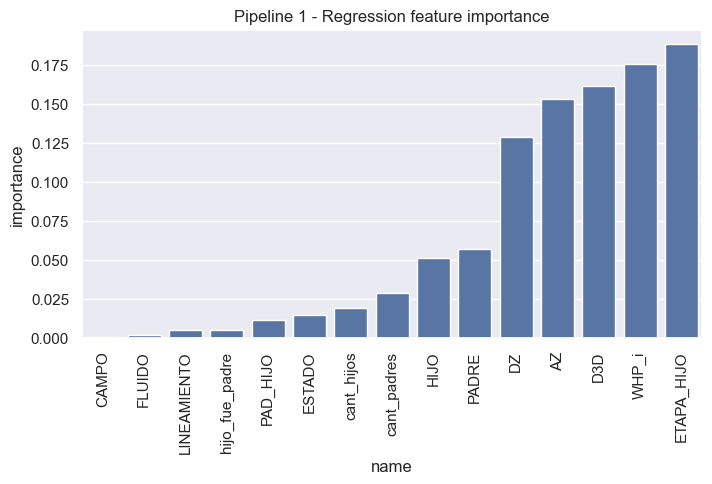

In [46]:
reg = reg.reg
feat_imp = pd.DataFrame(
    {"name": reg.feature_name_, "importance": reg.feature_importances_,}
).sort_values(by="importance")

feat_imp.importance /= feat_imp.importance.sum()

plt.figure(figsize=(8, 4))
plt.title("Pipeline 1 - Regression feature importance")
sns.barplot(x=feat_imp.name, y=feat_imp.importance, color="b")
plt.xticks(rotation=90)
plt.show()

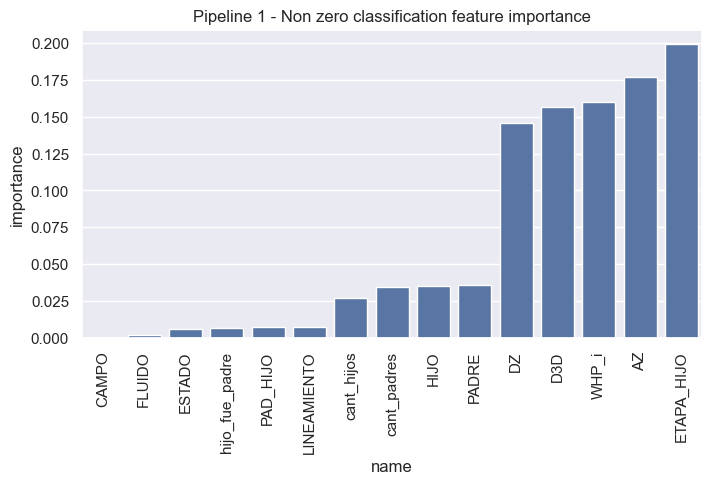

In [47]:
clf = clf.clf
feat_imp = pd.DataFrame(
    {"name": clf.feature_name_, "importance": clf.feature_importances_,}
).sort_values(by="importance")

feat_imp.importance /= feat_imp.importance.sum()

plt.figure(figsize=(8, 4))
plt.title("Pipeline 1 - Non zero classification feature importance")
sns.barplot(x=feat_imp.name, y=feat_imp.importance, color="b")
plt.xticks(rotation=90)
plt.show()

## Pipeline 2
Este es el referido al segundo modelo explicado anteriormente.

In [48]:
deltareg = Pipeline(
    steps=[
        ("add_previous_nz_deltas", PreviousNonZeroDeltas()),
        ("add_previous_nz_deltas_aggs", PreviousNonZeroDeltasAggs()),
        ("add_trig_features", TrigFeatures()),
        ("add_delta_statistical_summaries", WellDeltasStatisticalSummary()),
        (
            "feature_union",
            PandasFeatureAppender(
                [
                    ("hijo_fue_padre", HijoFuePadre()),
                    ("cant_hijos", CantHijos()),
                    ("cant_padres", CantPadres()),
                ]
            ),
        ),
        (
            "feature_selection",
            PandasColumnsSelector(
                categorical=[*CAT_COLS, "hijo_fue_padre"],
                numerical=[
                    *NUM_COLS,
                    "delta_sum",
                    "delta_mean",
                    "pnzd_agg_delta_sum",
                    "pnzd_agg_delta_mean",
                    "sin_AZ",
                    "cos_AZ",
                    "rho",
                    "cant_hijos",
                    "cant_padres",
                    "delta_agg_max",
                    "delta_agg_min",
                    "delta_agg_mean",
                    "delta_agg_median",
                    "delta_agg_std",
                    "delta_agg_var",
                ],
                remainder="drop",
            ),
        ),
        (
            "delta_predictions",
            FeatureUnion(
                [
                    ("nonzerodelta_prob", DeltaSignClassifier()),
                    ("delta_estimation", TweedieDeltaRegressor()),
                ]
            ),
        ),
        ("final_pred", JointEstimationRegressor()),
    ]
)

In [49]:
deltareg

Pipeline(steps=[('add_previous_nz_deltas', PreviousNonZeroDeltas()),
                ('add_previous_nz_deltas_aggs', PreviousNonZeroDeltasAggs()),
                ('add_trig_features', TrigFeatures()),
                ('add_delta_statistical_summaries',
                 WellDeltasStatisticalSummary()),
                ('feature_union',
                 PandasFeatureAppender(transformations=[('hijo_fue_padre',
                                                         HijoFuePadre()),
                                                        ('cant_hijos',
                                                         CantHijos()),
                                                        ('...
                                                  'pnzd_agg_delta_mean',
                                                  'sin_AZ', 'cos_AZ', 'rho',
                                                  'cant_hijos', 'cant_padres',
                                                  'delta_agg_max',
                                                  'delta_agg_min',
                                                  'delta_agg_mean',
                                                  'delta_agg_median',
                                                  'delta_agg_std',
                                                  'delta_agg_var'])),
                ('delta_predictions',
                 FeatureUnion(transformer_list=[('nonzerodelta_prob',
                                                 DeltaSignClassifier()),
                                                ('delta_estimation',
                                                 TweedieDeltaRegressor())])),
                ('final_pred', JointEstimationRegressor())])

### Grid Search Training

In [50]:
Xp = df_participantes.copy()
yp = df_participantes.delta_WHP.copy()

In [51]:
%%time

param_grid = {
    "feature_selection__numerical": [
        [
            *NUM_COLS,
            "delta_sum",
            "delta_mean",
            "pnzd_agg_delta_sum",
            "pnzd_agg_delta_mean",
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
        [
            *NUM_COLS,
            "delta_sum",
            "delta_mean",
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
        [
            *NUM_COLS,
            "pnzd_agg_delta_sum",
            "pnzd_agg_delta_mean",
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
        [
            *NUM_COLS,
            "sin_AZ",
            "cos_AZ",
            "rho",
            "cant_hijos",
            "cant_padres",
            "delta_agg_max",
            "delta_agg_min",
            "delta_agg_mean",
            "delta_agg_median",
            "delta_agg_std",
            "delta_agg_var",
        ],
    ],
    "delta_predictions__nonzerodelta_prob__objective": ["binary"],
    "delta_predictions__nonzerodelta_prob__random_state": [117],
    "delta_predictions__nonzerodelta_prob__boosting_type": ["gbdt"],
    "delta_predictions__nonzerodelta_prob__n_estimators": [25, 100, 300],
    "delta_predictions__nonzerodelta_prob__learning_rate": [0.1],
    "delta_predictions__nonzerodelta_prob__metric": ["binary_logloss"],
    "delta_predictions__nonzerodelta_prob__force_row_wise": [True],
    "delta_predictions__nonzerodelta_prob__importance_type": ["split"],
    "delta_predictions__nonzerodelta_prob__num_leaves": [3, 15, 31],
    "delta_predictions__nonzerodelta_prob__sample_weights": [
        None
    ],  # , "linear", "log"],
    "delta_predictions__nonzerodelta_prob__n_jobs": [1],
    "delta_predictions__delta_estimation__random_state": [117],
    "delta_predictions__delta_estimation__boosting_type": ["gbdt"],
    "delta_predictions__delta_estimation__n_estimators": [25, 100, 300],
    "delta_predictions__delta_estimation__learning_rate": [0.1],
    "delta_predictions__delta_estimation__metric": ["rmse"],
    "delta_predictions__delta_estimation__force_row_wise": [True],
    "delta_predictions__delta_estimation__importance_type": ["split"],
    "delta_predictions__delta_estimation__num_leaves": [3, 15, 31],
    "delta_predictions__delta_estimation__sample_weights": [
        None
    ],  # , "linear", "log"],
    "delta_predictions__delta_estimation__n_jobs": [1],
    "delta_predictions__delta_estimation__log_transform": [True],  # False
    "delta_predictions__delta_estimation__proportion_denom": [None],  # "WHP_i"
    #
    "final_pred__clip": [
        None,
        (-0.05, 0.05),
        (-0.1, 0.1),
        (-0.5, 0.5),
        (-1, 1),
        (-5, 5),
    ],
}

win_grid = {
    "delta_predictions__delta_estimation__boosting_type": "gbdt",
    "delta_predictions__delta_estimation__force_row_wise": True,
    "delta_predictions__delta_estimation__importance_type": "split",
    "delta_predictions__delta_estimation__learning_rate": 0.1,
    "delta_predictions__delta_estimation__log_transform": True,
    "delta_predictions__delta_estimation__metric": "rmse",
    "delta_predictions__delta_estimation__n_estimators": 500,
    "delta_predictions__delta_estimation__n_jobs": 1,
    "delta_predictions__delta_estimation__num_leaves": 31,
    "delta_predictions__delta_estimation__proportion_denom": None,
    "delta_predictions__delta_estimation__random_state": 117,
    "delta_predictions__delta_estimation__sample_weights": None,
    "delta_predictions__nonzerodelta_prob__boosting_type": "gbdt",
    "delta_predictions__nonzerodelta_prob__force_row_wise": True,
    "delta_predictions__nonzerodelta_prob__importance_type": "split",
    "delta_predictions__nonzerodelta_prob__learning_rate": 0.1,
    "delta_predictions__nonzerodelta_prob__metric": "binary_logloss",
    "delta_predictions__nonzerodelta_prob__n_estimators": 500,
    "delta_predictions__nonzerodelta_prob__n_jobs": 1,
    "delta_predictions__nonzerodelta_prob__num_leaves": 31,
    "delta_predictions__nonzerodelta_prob__objective": "binary",
    "delta_predictions__nonzerodelta_prob__random_state": 117,
    "delta_predictions__nonzerodelta_prob__sample_weights": None,
    "feature_selection__numerical": [
        "D3D",
        # "D2D",
        "DZ",
        "AZ",
        "WHP_i",
        "ETAPA_HIJO",
        # "CANT_BARRERAS",
        # "sin_AZ",
        # "cos_AZ",
        # "rho",
        "cant_hijos",
        "cant_padres",
        # "delta_agg_max",
        # "delta_agg_min",
        # "delta_agg_mean",
        # "delta_agg_median",
        # "delta_agg_std",
        # "delta_agg_var",
        # "delta_last_known",
        # "log_delta_last_known"
    ],
    "final_pred__clip": (-1, 1),
}

param_grid = {k: [v] for k, v in win_grid.items()}

gscv_p2 = GridSearchCV(
    deltareg,
    param_grid=param_grid,
    n_jobs=-1,
    refit=True,
    cv=20,  # 5 if not using winning grid
    # cv=5,
    verbose=1,
    scoring="neg_mean_absolute_error",
    error_score="raise",
)
gscv_p2.fit(Xp, yp)

Fitting 20 folds for each of 1 candidates, totalling 20 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
CPU times: user 7.21 s, sys: 63.5 ms, total: 7.28 s
Wall time: 19.7 s


GridSearchCV(cv=20, error_score='raise',
             estimator=Pipeline(steps=[('add_previous_nz_deltas',
                                        PreviousNonZeroDeltas()),
                                       ('add_previous_nz_deltas_aggs',
                                        PreviousNonZeroDeltasAggs()),
                                       ('add_trig_features', TrigFeatures()),
                                       ('add_delta_statistical_summaries',
                                        WellDeltasStatisticalSummary()),
                                       ('feature_union',
                                        PandasFeatureAppender(transformations=[('hijo_fue_pad...
                         'delta_predictions__nonzerodelta_prob__objective': ['binary'],
                         'delta_predictions__nonzerodelta_prob__random_state': [117],
                         'delta_predictions__nonzerodelta_prob__sample_weights': [None],
                         'feature_selection__numerical': [['D3D', 'DZ', 'AZ',
                                                           'WHP_i',
                                                           'ETAPA_HIJO',
                                                           'cant_hijos',
                                                           'cant_padres']],
                         'final_pred__clip': [(-1, 1)]},
             scoring='neg_mean_absolute_error', verbose=1)

In [52]:
print(gscv_p2.best_score_)
# pprint(
#    {
#        k: v
#        for k, v in gscv_p2.cv_results_.items()
#        if k.startswith("split") and k.endswith("_test_score")
#    }
# )
pprint(gscv_p2.best_params_)

-1.0992955835684195
{'delta_predictions__delta_estimation__boosting_type': 'gbdt',
 'delta_predictions__delta_estimation__force_row_wise': True,
 'delta_predictions__delta_estimation__importance_type': 'split',
 'delta_predictions__delta_estimation__learning_rate': 0.1,
 'delta_predictions__delta_estimation__log_transform': True,
 'delta_predictions__delta_estimation__metric': 'rmse',
 'delta_predictions__delta_estimation__n_estimators': 500,
 'delta_predictions__delta_estimation__n_jobs': 1,
 'delta_predictions__delta_estimation__num_leaves': 31,
 'delta_predictions__delta_estimation__proportion_denom': None,
 'delta_predictions__delta_estimation__random_state': 117,
 'delta_predictions__delta_estimation__sample_weights': None,
 'delta_predictions__nonzerodelta_prob__boosting_type': 'gbdt',
 'delta_predictions__nonzerodelta_prob__force_row_wise': True,
 'delta_predictions__nonzerodelta_prob__importance_type': 'split',
 'delta_predictions__nonzerodelta_prob__learning_rate': 0.1,
 'delt

### Feature importance

In [53]:
(_, clf), (_, reg) = gscv_p2.best_estimator_["delta_predictions"].transformer_list

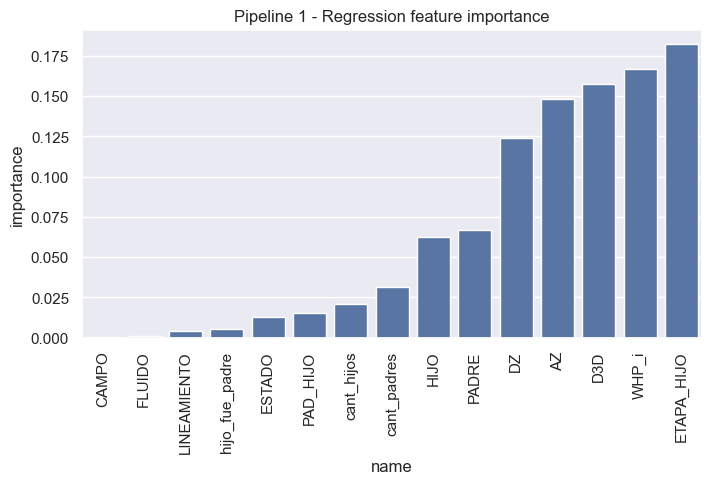

In [54]:
reg = reg.reg
feat_imp = pd.DataFrame(
    {"name": reg.feature_name_, "importance": reg.feature_importances_,}
).sort_values(by="importance")

feat_imp.importance /= feat_imp.importance.sum()

plt.figure(figsize=(8, 4))
plt.title("Pipeline 1 - Regression feature importance")
sns.barplot(x=feat_imp.name, y=feat_imp.importance, color="b")
plt.xticks(rotation=90)
plt.show()

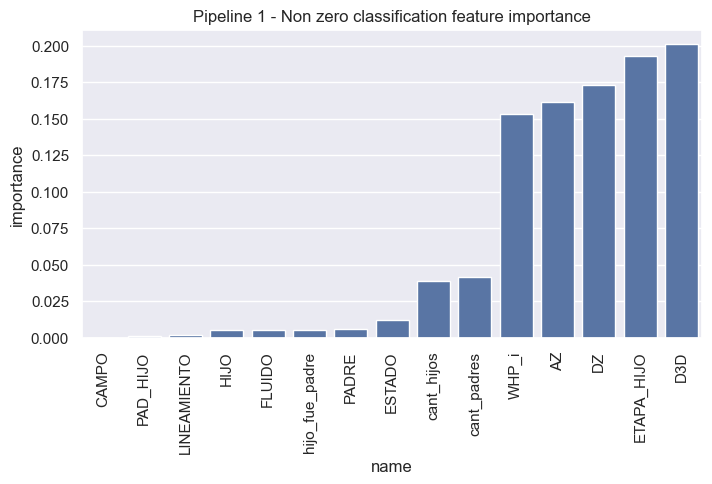

In [55]:
clf = clf.clf
feat_imp = pd.DataFrame(
    {"name": clf.feature_name_, "importance": clf.feature_importances_,}
).sort_values(by="importance")

feat_imp.importance /= feat_imp.importance.sum()

plt.figure(figsize=(8, 4))
plt.title("Pipeline 1 - Non zero classification feature importance")
sns.barplot(x=feat_imp.name, y=feat_imp.importance, color="b")
plt.xticks(rotation=90)
plt.show()

# Ensemble de ambos modelos
Si bien ambos modelos tienen métricas similares, es de esperar que no fallen del mismo modo. Hacemos un pequeño ensamble promediando ambos modelos.

## Pipeline

In [56]:
from sklearn.linear_model import LinearRegression


class EnsemblePredictor(BaseEstimator, TransformerMixin, RegressorMixin):
    """Modelo final que aprende sobre las predicciones anteriores."""

    def __init__(
        self,
        mode="joint",
        pairs=(
            ("nonzerodelta_prob", "delta_estimation"),
            ("deltasign_prob", "tweedie_estimation"),
        ),
        clip=None,
        agg="avg",
    ):
        if mode not in ("raw", "joint", "full"):
            raise ValueError("Only None and joint are supported modes")

        if agg not in ("avg", "pred"):
            raise ValueError("Only avg and pred are valid aggregations")

        self.mode = mode
        self.pairs = pairs
        self.clip = clip
        self.agg = agg

    def fit(self, X, y=None):
        self.model = lgbm.LGBMRegressor(n_estimators=10)
        self.lr = LinearRegression()

        X = self.transform(X)

        if self.mode == "joint":
            self.features = [f"pred{i}" for i in range(len(self.pairs))]
        elif self.mode == "full":
            self.features = [*X.columns.to_list()]
        else:  # raw
            self.features = [x[0] for x in self.pairs] + [x[1] for x in self.pairs]

        self.model.fit(X[self.features], y)
        if self.mode == "joint":
            self.lr.fit(X[self.features], y)
        return self

    def transform(self, X):
        for i, (p0, p1) in enumerate(self.pairs):
            X[f"pred{i}"] = X[p0] * X[p1]
            # X = X.drop(columns=[p0, p1])

        for i in range(len(self.pairs)):
            for j in range(i + 1, len(self.pairs)):
                X[f"diff_{i}_{j}"] = X[f"pred{i}"] - X[f"pred{j}"]

        return X

    def predict(self, X):
        X = self.transform(X)
        if self.agg == "pred":
            if self.mode == "joint":
                pred = self.lr.predict(X[self.features])
            else:
                pred = self.model.predict(X[self.features])
        else:  # avg
            pred = (X["pred0"] + X["pred1"]) / 2

        if self.clip is not None:
            lower_bound, upper_bound = self.clip
            pred[(pred > lower_bound) & (pred < upper_bound)] = 0

        return pred

In [57]:
merge_pipeline = Pipeline(
    steps=[
        ("add_previous_nz_deltas", PreviousNonZeroDeltas()),
        ("add_previous_nz_deltas_aggs", PreviousNonZeroDeltasAggs()),
        ("add_trig_features", TrigFeatures()),
        ("add_delta_statistical_summaries", WellDeltasStatisticalSummary()),
        (
            "feature_union",
            PandasFeatureAppender(
                [
                    ("hijo_fue_padre", HijoFuePadre()),
                    ("cant_hijos", CantHijos()),
                    ("cant_padres", CantPadres()),
                ]
            ),
        ),
        (
            "feature_selection",
            PandasColumnsSelector(
                categorical=[*CAT_COLS, "hijo_fue_padre"],
                numerical=[
                    *NUM_COLS,
                    # "delta_sum",
                    # "delta_mean",
                    # "pnzd_agg_delta_sum",
                    # "pnzd_agg_delta_mean",
                    "sin_AZ",
                    "cos_AZ",
                    "rho",
                    "cant_hijos",
                    "cant_padres",
                    "delta_agg_max",
                    "delta_agg_min",
                    "delta_agg_mean",
                    "delta_agg_median",
                    "delta_agg_std",
                    "delta_agg_var",
                ],
                remainder="drop",
            ),
        ),
        (
            "delta_predictions",
            FeatureUnion(
                [
                    ("nonzerodelta_prob", DeltaBinaryTargetClassifier()),
                    ("delta_estimation", NonZeroDeltaRegressor()),
                    ("deltasign_prob", DeltaSignClassifier()),
                    ("tweedie_estimation", TweedieDeltaRegressor()),
                    ("passthrough", "passthrough"),
                ]
            ),
        ),
        (
            "final_feature_selection",
            PandasColumnsSelector(
                categorical=[*CAT_COLS, "hijo_fue_padre"],
                numerical=[
                    *NUM_COLS,
                    # "delta_sum",
                    # "delta_mean",
                    # "pnzd_agg_delta_sum",
                    # "pnzd_agg_delta_mean",
                    "sin_AZ",
                    "cos_AZ",
                    "rho",
                    "cant_hijos",
                    "cant_padres",
                    "delta_agg_max",
                    "delta_agg_min",
                    "delta_agg_mean",
                    "delta_agg_median",
                    "delta_agg_std",
                    "delta_agg_var",
                    "nonzerodelta_prob",
                    "delta_estimation",
                    "deltasign_prob",
                    "tweedie_estimation",
                ],
                remainder="drop",
                order=[
                    "nonzerodelta_prob",
                    "delta_estimation",
                    "deltasign_prob",
                    "tweedie_estimation",
                    "group::categorical",
                    "group::numerical",
                ],
            ),
        ),
        ("final_pred", EnsemblePredictor()),
    ]
)


# ("final_pred", EnsemblePredictor()),
merge_pipeline

Pipeline(steps=[('add_previous_nz_deltas', PreviousNonZeroDeltas()),
                ('add_previous_nz_deltas_aggs', PreviousNonZeroDeltasAggs()),
                ('add_trig_features', TrigFeatures()),
                ('add_delta_statistical_summaries',
                 WellDeltasStatisticalSummary()),
                ('feature_union',
                 PandasFeatureAppender(transformations=[('hijo_fue_padre',
                                                         HijoFuePadre()),
                                                        ('cant_hijos',
                                                         CantHijos()),
                                                        ('...
                                                  'cant_padres',
                                                  'delta_agg_max',
                                                  'delta_agg_min',
                                                  'delta_agg_mean',
                                                  'delta_agg_median',
                                                  'delta_agg_std',
                                                  'delta_agg_var',
                                                  'nonzerodelta_prob',
                                                  'delta_estimation',
                                                  'deltasign_prob',
                                                  'tweedie_estimation'],
                                       order=['nonzerodelta_prob',
                                              'delta_estimation',
                                              'deltasign_prob',
                                              'tweedie_estimation',
                                              'group::categorical',
                                              'group::numerical'])),
                ('final_pred', EnsemblePredictor())])

### Grid search

In [58]:
win_grid = {
    "delta_predictions__delta_estimation__boosting_type": "gbdt",
    "delta_predictions__delta_estimation__force_row_wise": True,
    "delta_predictions__delta_estimation__importance_type": "split",
    "delta_predictions__delta_estimation__learning_rate": 0.1,
    "delta_predictions__delta_estimation__log_transform": True,
    "delta_predictions__delta_estimation__metric": "rmse",
    "delta_predictions__delta_estimation__n_estimators": 500,
    "delta_predictions__delta_estimation__n_jobs": 1,
    "delta_predictions__delta_estimation__num_leaves": 31,
    "delta_predictions__delta_estimation__objective": "regression_l2",
    "delta_predictions__delta_estimation__proportion_denom": None,
    "delta_predictions__delta_estimation__random_state": 117,
    "delta_predictions__delta_estimation__sample_weights": None,
    "delta_predictions__delta_estimation__truncate_zero": False,
    "delta_predictions__deltasign_prob__boosting_type": "gbdt",
    "delta_predictions__deltasign_prob__force_row_wise": True,
    "delta_predictions__deltasign_prob__importance_type": "split",
    "delta_predictions__deltasign_prob__learning_rate": 0.1,
    "delta_predictions__deltasign_prob__metric": "binary_logloss",
    "delta_predictions__deltasign_prob__n_estimators": 500,
    "delta_predictions__deltasign_prob__n_jobs": 1,
    "delta_predictions__deltasign_prob__num_leaves": 31,
    "delta_predictions__deltasign_prob__objective": "binary",
    "delta_predictions__deltasign_prob__random_state": 117,
    "delta_predictions__deltasign_prob__sample_weights": None,
    "delta_predictions__nonzerodelta_prob__boosting_type": "gbdt",
    "delta_predictions__nonzerodelta_prob__force_row_wise": True,
    "delta_predictions__nonzerodelta_prob__importance_type": "split",
    "delta_predictions__nonzerodelta_prob__learning_rate": 0.1,
    "delta_predictions__nonzerodelta_prob__metric": "cross_entropy",
    "delta_predictions__nonzerodelta_prob__n_estimators": 500,
    "delta_predictions__nonzerodelta_prob__n_jobs": 1,
    "delta_predictions__nonzerodelta_prob__num_leaves": 31,
    "delta_predictions__nonzerodelta_prob__objective": "cross_entropy",
    "delta_predictions__nonzerodelta_prob__random_state": 117,
    "delta_predictions__nonzerodelta_prob__sample_weights": None,
    "delta_predictions__tweedie_estimation__boosting_type": "gbdt",
    "delta_predictions__tweedie_estimation__force_row_wise": True,
    "delta_predictions__tweedie_estimation__importance_type": "split",
    "delta_predictions__tweedie_estimation__learning_rate": 0.1,
    "delta_predictions__tweedie_estimation__log_transform": True,
    "delta_predictions__tweedie_estimation__metric": "rmse",
    "delta_predictions__tweedie_estimation__n_estimators": 500,
    "delta_predictions__tweedie_estimation__n_jobs": 1,
    "delta_predictions__tweedie_estimation__num_leaves": 31,
    "delta_predictions__tweedie_estimation__proportion_denom": None,
    "delta_predictions__tweedie_estimation__random_state": 117,
    "delta_predictions__tweedie_estimation__sample_weights": None,
    "feature_selection__numerical": [
        "D3D",
        "D2D",
        "DZ",
        "AZ",
        "WHP_i",
        "ETAPA_HIJO",
        # "CANT_BARRERAS",
        # "sin_AZ",
        # "cos_AZ",
        # "rho",
        "cant_hijos",
        "cant_padres",
        # "delta_agg_max",
        # "delta_agg_min",
        # "delta_agg_mean",
        # "delta_agg_median",
        # "delta_agg_std",
        # "delta_agg_var",
    ],
    "final_feature_selection__numerical": [
        "nonzerodelta_prob",
        "delta_estimation",
        "deltasign_prob",
        "tweedie_estimation",
        "D3D",
        "D2D",
        "DZ",
        "AZ",
        "WHP_i",
        "ETAPA_HIJO",
        # "CANT_BARRERAS",
        # "sin_AZ",
        # "cos_AZ",
        # "rho",
        "cant_hijos",
        "cant_padres",
        # "delta_agg_max",
        # "delta_agg_min",
        # "delta_agg_mean",
        # "delta_agg_median",
        # "delta_agg_std",
        # "delta_agg_var",
    ],
    "final_feature_selection__order": [
        "nonzerodelta_prob",
        "delta_estimation",
        "deltasign_prob",
        "tweedie_estimation",
        "group::categorical",
        "group::numerical",
    ],
    "final_pred__agg": "avg",
    "final_pred__clip": (-1.0, 1.0),
    "final_pred__mode": "joint",
}

param_grid = {k: [v] for k, v in win_grid.items()}
# param_grid["final_pred__agg"] = ["avg", "pred"]
# param_grid["final_pred__mode"] = ["joint", "full", "raw"]


gscv_m = GridSearchCV(
    merge_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    refit=True,
    cv=20,
    verbose=1,
    scoring="neg_mean_absolute_error",
    error_score="raise",
)

Xp = df_participantes.copy()
yp = df_participantes.delta_WHP.copy()

gscv_m.fit(Xp, yp)

Fitting 20 folds for each of 1 candidates, totalling 20 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current val

GridSearchCV(cv=20, error_score='raise',
             estimator=Pipeline(steps=[('add_previous_nz_deltas',
                                        PreviousNonZeroDeltas()),
                                       ('add_previous_nz_deltas_aggs',
                                        PreviousNonZeroDeltasAggs()),
                                       ('add_trig_features', TrigFeatures()),
                                       ('add_delta_statistical_summaries',
                                        WellDeltasStatisticalSummary()),
                                       ('feature_union',
                                        PandasFeatureAppender(transformations=[('hijo_fue_pad...
                         'delta_predictions__nonzerodelta_prob__boosting_type': ['gbdt'],
                         'delta_predictions__nonzerodelta_prob__force_row_wise': [True],
                         'delta_predictions__nonzerodelta_prob__importance_type': ['split'],
                         'delta_predictions__nonzerodelta_prob__learning_rate': [0.1],
                         'delta_predictions__nonzerodelta_prob__metric': ['cross_entropy'], ...},
             scoring='neg_mean_absolute_error', verbose=1)

In [59]:
print(gscv_m.best_score_)
# pprint(
#    {
#        k: v
#        for k, v in gscv_m.cv_results_.items()
#        if k.startswith("split") and k.endswith("_test_score")
#    }
# )
pprint(gscv_m.best_params_)

-1.0696001884901052
{'delta_predictions__delta_estimation__boosting_type': 'gbdt',
 'delta_predictions__delta_estimation__force_row_wise': True,
 'delta_predictions__delta_estimation__importance_type': 'split',
 'delta_predictions__delta_estimation__learning_rate': 0.1,
 'delta_predictions__delta_estimation__log_transform': True,
 'delta_predictions__delta_estimation__metric': 'rmse',
 'delta_predictions__delta_estimation__n_estimators': 500,
 'delta_predictions__delta_estimation__n_jobs': 1,
 'delta_predictions__delta_estimation__num_leaves': 31,
 'delta_predictions__delta_estimation__objective': 'regression_l2',
 'delta_predictions__delta_estimation__proportion_denom': None,
 'delta_predictions__delta_estimation__random_state': 117,
 'delta_predictions__delta_estimation__sample_weights': None,
 'delta_predictions__delta_estimation__truncate_zero': False,
 'delta_predictions__deltasign_prob__boosting_type': 'gbdt',
 'delta_predictions__deltasign_prob__force_row_wise': True,
 'delta_pr

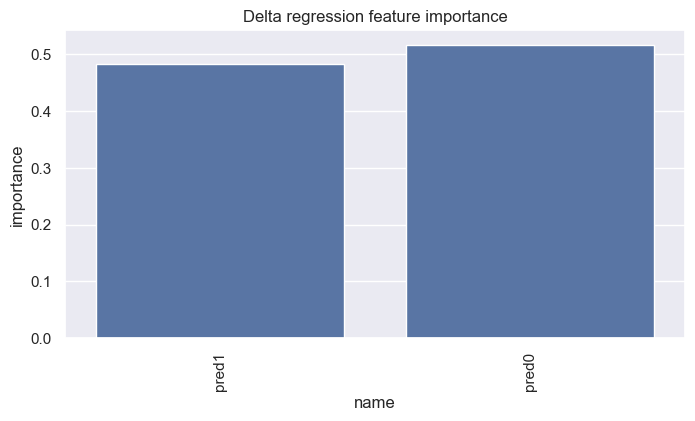

In [60]:
reg = gscv_m.best_estimator_["final_pred"].model
feat_imp = pd.DataFrame(
    {"name": reg.feature_name_, "importance": reg.feature_importances_,}
).sort_values(by="importance")

feat_imp.importance /= feat_imp.importance.sum()

plt.figure(figsize=(8, 4))
plt.title("Delta regression feature importance")
sns.barplot(x=feat_imp.name, y=feat_imp.importance, color="b")
plt.xticks(rotation=90)
plt.show()

# Residuos

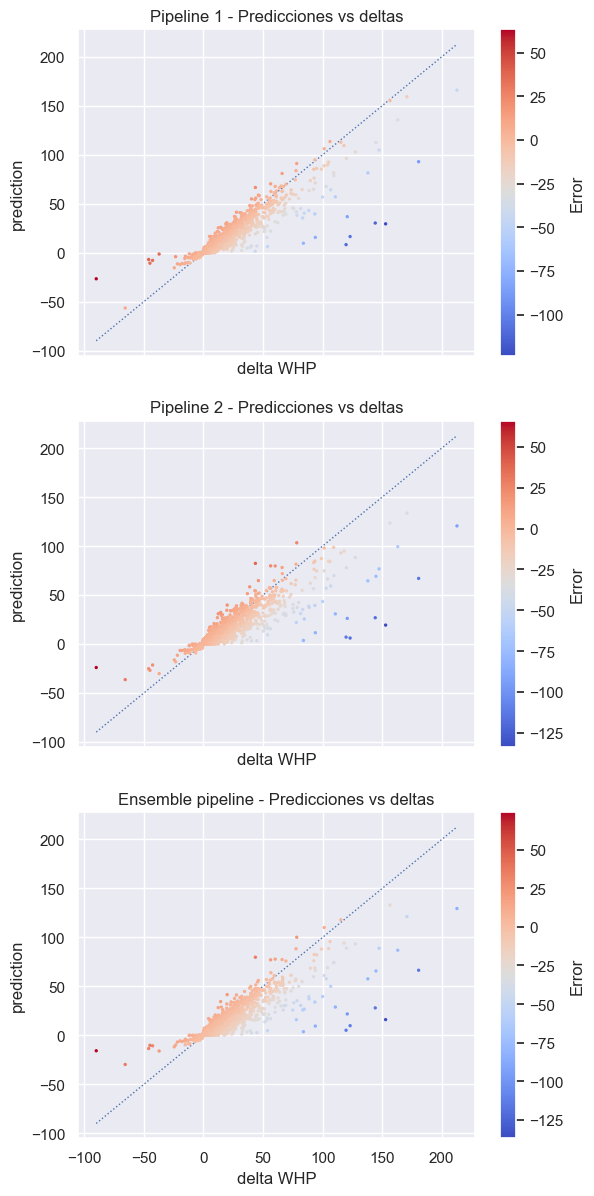

In [90]:
fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=3, ncols=1, figsize=(6.4, 4.8*3), dpi=100, sharey=True, sharex=True
)

preds = gscv_p1.predict(df_participantes).reshape(-1)
c = preds - df_participantes.delta_WHP
sp0 = ax0.scatter(df_participantes.delta_WHP, preds, s=2, c=c, zorder=2, cmap="coolwarm")
ax0.set_xlabel("delta WHP")
ax0.set_ylabel("prediction")
ax0.set_title("Pipeline 1 - Predicciones vs deltas")

xl = yl = min(df_participantes.delta_WHP.min(), preds.min())
xr = yr = max(df_participantes.delta_WHP.max(), preds.max())
ax0.plot((xl, xr), (yl, yr), linestyle=":", linewidth=1, zorder=1)

fig.colorbar(sp0, ax=ax0, label="Error")

preds = gscv_p2.predict(df_participantes).reshape(-1)
c = preds - df_participantes.delta_WHP
sp1 = ax1.scatter(df_participantes.delta_WHP, preds, s=2, c=c, zorder=2, cmap="coolwarm")
ax1.set_xlabel("delta WHP")
ax1.set_ylabel("prediction")
ax1.set_title("Pipeline 2 - Predicciones vs deltas")

xl = yl = min(df_participantes.delta_WHP.min(), preds.min())
xr = yr = max(df_participantes.delta_WHP.max(), preds.max())
ax1.plot((xl, xr), (yl, yr), linestyle=":", linewidth=1, zorder=1)

fig.colorbar(sp1, ax=ax1, label="Error")

preds = gscv_m.predict(df_participantes)
c = preds - df_participantes.delta_WHP
sp2 = ax2.scatter(df_participantes.delta_WHP, preds, s=2, c=c, zorder=2, cmap="coolwarm")
ax2.set_xlabel("delta WHP")
ax2.set_ylabel("prediction")
ax2.set_title("Ensemble pipeline - Predicciones vs deltas")

xl = yl = min(df_participantes.delta_WHP.min(), preds.min())
xr = yr = max(df_participantes.delta_WHP.max(), preds.max())
ax2.plot((xl, xr), (yl, yr), linestyle=":", linewidth=1, zorder=1)

fig.colorbar(sp2, ax=ax2, label="Error")

plt.show()

El error parece ser aleatorio, no hay ningún patrón a simple vista. Si es claro que los outliers se llevan gran parte del error.

In [91]:
df_participantes["predm"] = gscv_m.predict(df_participantes)
df_participantes["pred1"] = gscv_p1.predict(df_participantes)
df_participantes["pred2"] = gscv_p2.predict(df_participantes)

# Predecir para el dataset de test

In [92]:
from datetime import datetime

In [93]:
df_pred = pd.read_csv("Dataset evaluación (corregido).csv")
df_pred.rename(columns={"#_BARRERAS": "CANT_BARRERAS"}, inplace=True)
df_pred.CANT_BARRERAS = df_pred.CANT_BARRERAS.astype(int)

In [94]:
assert not df_pred.ID_FILA.isin(df_participantes.ID_FILA).any()

In [95]:
df_pred.D3D = df_pred.D3D.astype(str).str.replace(",", ".").astype(float)
df_pred.WHP_i = df_pred.WHP_i.astype(str).str.replace(",", ".").astype(float)

In [96]:
expon = np.log10(df_pred.AZ).round()
expon = (expon >= 3) * (df_pred.AZ > 360) * expon
df_pred.AZ /= np.power(10, expon)

/home/nox/repos/venv/lib64/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [97]:
expon = np.log10(df_pred.D2D / df_pred.D3D).round()
expon = (expon >= 3) * expon
df_pred.D2D /= np.power(10, expon)

In [98]:
expon = np.log10(df_pred.D3D / df_pred.D2D).round()
expon = (expon >= 3) * expon
df_pred.D3D /= np.power(10, expon)

In [99]:
# Imputacion manual basada en el pozo padre y el hijo
df_pred.loc[3688, "D3D"] = 659.96282
df_pred.loc[3688, "D2D"] = 659.96276
df_pred.loc[3688, "AZ"] = 273.044018

In [100]:
df_pred["pred1"] = gscv_p1.predict(df_pred)
df_pred["pred2"] = gscv_p2.predict(df_pred)
df_pred["predm"] = gscv_m.predict(df_pred)

In [101]:
df_pred[["ID_FILA", "pred1"]].to_csv(
    f"predicciones_iterate_1_{datetime.now()}.csv", header=False, index=False
)

In [102]:
df_pred[["ID_FILA", "pred2"]].to_csv(
    f"predicciones_iterate_2_{datetime.now()}.csv", header=False, index=False
)

In [103]:
df_pred[["ID_FILA", "predm"]].to_csv(
    f"predicciones_iterate_m_{datetime.now()}.csv", header=False, index=False
)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fractio

# Conclusiones

## Sobre el dataset
Considero que hay ciertas features que podrían ser agregadas y aportarían gran valor. En primer lugar, en lugar de dar features de distancias, teniendo ubicaciones (como pares de latitud y longitud) de las etapas de cada pozo, se podría hacer un análisis mucho mas riguroso de la geometría del problema. Esta data se puede fácilmente enmascarar con traslaciones, rotaciones y expansiones lineales, de modo que si fuera información que se prefiera no divulgar, no sea útil sin conocer dichas transformaciones.

En segundo lugar, tener el timestamp de las mediciones sería útil para armar la cronología de interferencias para cada pozo. En un entorno productivo, esto sería más correcto: dado que podríamos asegurar que estamos validando nuestro modelo con data futura, y que no tenemos filtraciones temporales.

## Sobre el modelo entregado
En base a las métricas de cross validation, el modelo entregado se corresponde al ensemble de ambos modelos. Si bien los otros dos tienen una excelente performance, y son mas sencillos, este modelo tiene mejores métricas. Habría que considerar si se requiere la interpretabilidad que pueden proveer modelos mas sencillos.

## Sobre las features comentadas
Muchas features del pipeline fueron filtradas dado que al correr un grid search exhaustivo, daban peores métricas. El resultado es un modelo mucho más sencillo y fácil de explicar. Sin embargo, considerando las features provistas, me parece que se ha explorado exhaustivamente el feature engineering posible.

Varias de estas features probablemente dominaran el entrenamiento pero hicieran el modelo muy propenso a overfittear, por tanto el resultado promediado entre folds no sería tan bueno.

## Generales
El modelo desarrollado ha sido competitivo. Hay posible trabajo futuro en optimización de hiperparametros, feature engineering, y testeo del código desarrollado.

Un aspecto que no desarrollé es el de la calibración de los modelos. Siendo que en el primer pipeline estamos usando la salida del modelo como una probabilidad, nos interesa asegurarnos que el modelo esté bien calibrado. Es decir, si tenemos $N$ observaciones para las cuales el modelo predice $0.8$, esperamos que el %80 de esas observaciones sean positivas. No lo hice porque al no tener los folds, no era tan cómodo para hacer el gráfico, y usarlo como métrica es en general, mala idea si no se acompaña por otras, dificultando el proceso de selección automática del modelo. Pensé en hacer el gráfico como scorer, pero entonces el notebook se haría eterno al tener 20 plots por entrenamiento... lo cual no es cómodo para el lector ni el desarrollador.